In [2]:
import numpy as np
import random
from PIL import Image 
import matplotlib.pyplot as plt
import torch
import os
import torchvision.transforms as transforms
import torchvision

In [3]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
IMG_SIZE = 64

In [16]:
def image_read(path):
    resize = transforms.Resize([IMG_SIZE, IMG_SIZE])
    x = torch.FloatTensor(1, 3, IMG_SIZE, IMG_SIZE)
    for dirname, _, filenames in os.walk(os.path.join(path)):
        for filename in filenames:
                img = Image.open(os.path.join(path,filename))
                to_tensor = transforms.ToTensor()
                
                img = resize(img)
                mirror_img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
                tensor = to_tensor(img)
                mirror_tensor = to_tensor(mirror_img)
                #print(tensor.dtype)
                #print(tensor.shape)
                
                new_x = torch.cat([x, tensor.unsqueeze(0)], 0)                 
                x = new_x   
                new_x = torch.cat([x, mirror_tensor.unsqueeze(0)], 0)    
                x = new_x
                #print(x.shape)
    return x[1:] 

paths = [r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02107574-Greater_Swiss_Mountain_dog',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02107683-Bernese_mountain_dog',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02107908-Appenzeller', 
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02091134-whippet',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02085620-Chihuahua',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02088364-beagle', 
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02089078-black-and-tan_coonhound',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02089867-Walker_hound',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02089973-English_foxhound'
        ]

In [17]:
paths = [r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02107574-Greater_Swiss_Mountain_dog',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02107683-Bernese_mountain_dog',
         r'C:\Users\38050\Desktop\programming\python\notebook\dogs_v2\images\Images\n02107908-Appenzeller'
        ]

In [18]:
images = torch.cat([image_read(path) for path in paths], 0).to(device)

In [19]:

print(images.shape)

torch.Size([1074, 3, 64, 64])


In [20]:
class G(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.main = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, 48, 2, stride=1),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose2d(48, 32, 3, stride=3, padding=1),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose2d(32, 24, 3, stride=2, padding=1),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose2d(24, 16, 3, stride=2, padding=1),
            torch.nn.Tanh(),
            torch.nn.ConvTranspose2d(16, 6, 3, stride=2, padding=1, output_padding=1), #output_padding=1
            torch.nn.Tanh(),
            torch.nn.ConvTranspose2d(6, 3, 4, stride=2, padding=1), #output_padding=1
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        generated = self.main(torch.normal(0, 1.0, size=(x, 64, 1, 1)).to(device))
        return generated

generator = G().to(device)

In [21]:
class C(torch.nn.Module): # experiment zone !!!  
    def __init__(self):
        super().__init__()        
        self.main = torch.nn.Sequential(
            torch.nn.Conv2d(3, 6, 4, stride=2, padding=1), # n*6*32*32  #first argument is 1, because the number of channels in blackNwhite = 1
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(6, 16, 3, stride=2, padding=1),  # n*16*10*10 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(16, 24, 3, stride=2, padding=1), # 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(24, 32, 3, stride=2, padding=1), # 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 48, 3, stride=3, padding=1), # 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(48, 64, 2, stride=1, padding=0), # 
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(64, 1),
            torch.nn.Sigmoid()
            
        )
        
    def forward(self, x):
        #x = x.view(x.size(0), size1*size2*size3)
        encoded = self.main(x)
        
        return encoded

critic = C().to(device)

In [22]:
loss = torch.nn.BCELoss()
optimizerC = torch.optim.Adam(critic.parameters(), lr=2.0e-4, weight_decay=1e-5, betas=(0.5, 0.5))
optimizerG = torch.optim.Adam(generator.parameters(), lr=2.0e-4, weight_decay=1e-5, betas=(0.5, 0.5))

In [23]:
epochs = 500
batch_size = 64
real_labels = torch.ones(batch_size, 1).to(device) - 0.1
real_labelsG = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)
outputs = []
for epoch in range(epochs):
    order = np.random.permutation(len(images))
    G_total_loss  = 0
    C_total_loss = 0
    print(epoch)
    for start_index in range(0, images.size(0), batch_size):
        batch_indices = order[start_index:start_index+batch_size]
        
        X_batch = images[batch_indices]
        #real_batch = real_labels[batch_indices]
        
        # critic train 
        C_out = critic.forward(X_batch)
        shape_Xbatch = X_batch.shape[0]
        C_loss_real = loss(C_out, real_labels[:shape_Xbatch])
        #print("C_out X_batch", C_out)
        
        
        C_out = critic.forward(generator.forward(batch_size))
        #print("C_out genearted", C_out)
        C_loss_fake = loss(C_out, fake_labels)
        
        C_loss = C_loss_fake + C_loss_real
        
        optimizerC.zero_grad()
        optimizerG.zero_grad()
        C_loss.backward()
        optimizerC.step()
        
        C_total_loss += C_loss.item()
        print("C_fake", C_loss_fake.item(), "C_real", C_loss_real.item())
        #print(C_loss_fake, C_loss_real, C_total_loss)
        
        # generator train 
        G_out = critic.forward(generator.forward(batch_size))
        G_loss = loss(G_out, real_labelsG)
        print("G_loss", G_loss.item())
        optimizerG.zero_grad()
        optimizerC.zero_grad()
        G_loss.backward()
        optimizerG.step()
        
        G_total_loss += G_loss.item()
        #print(G_total_loss)
        
    
    

0
C_fake 0.6730486154556274 C_real 0.7097495794296265
G_loss 0.7154605984687805
C_fake 0.6713216304779053 C_real 0.7110079526901245
G_loss 0.71720290184021
C_fake 0.6696574091911316 C_real 0.7122753858566284
G_loss 0.7189580202102661
C_fake 0.6679865121841431 C_real 0.7133322358131409
G_loss 0.7206765413284302
C_fake 0.666355550289154 C_real 0.714453935623169
G_loss 0.7223732471466064
C_fake 0.6647516489028931 C_real 0.7155573964118958
G_loss 0.7240782976150513
C_fake 0.6631442904472351 C_real 0.7166688442230225
G_loss 0.725753664970398
C_fake 0.6615709662437439 C_real 0.7177146077156067
G_loss 0.7273381948471069
C_fake 0.6600874662399292 C_real 0.7185157537460327
G_loss 0.7287614345550537
C_fake 0.6587584018707275 C_real 0.7193124294281006
G_loss 0.7302749156951904
C_fake 0.6573493480682373 C_real 0.7201635837554932
G_loss 0.7318731546401978
C_fake 0.6558660268783569 C_real 0.7209868431091309
G_loss 0.7335289716720581
C_fake 0.6543344259262085 C_real 0.7218809127807617
G_loss 0.735252

C_fake 0.018059207126498222 C_real 0.3604949116706848
G_loss 4.0989885330200195
C_fake 0.01680096797645092 C_real 0.35096269845962524
G_loss 4.186670303344727
C_fake 0.015364112332463264 C_real 0.37177276611328125
G_loss 4.210485935211182
C_fake 0.01499871164560318 C_real 0.35612574219703674
G_loss 4.228296279907227
C_fake 0.014745580032467842 C_real 0.35001474618911743
G_loss 4.249878883361816
C_fake 0.014426080510020256 C_real 0.3602640628814697
G_loss 4.25387716293335
C_fake 0.014365099370479584 C_real 0.35106828808784485
G_loss 4.24483585357666
C_fake 0.014495925977826118 C_real 0.3493821620941162
G_loss 4.345757961273193
C_fake 0.013098122552037239 C_real 0.3467804193496704
G_loss 4.484017848968506
C_fake 0.011418155394494534 C_real 0.35185372829437256
G_loss 4.573083877563477
C_fake 0.010428343899548054 C_real 0.3583757281303406
G_loss 4.537853240966797
C_fake 0.01082202885299921 C_real 0.342570960521698
G_loss 4.599811553955078
C_fake 0.010161603800952435 C_real 0.34146639704704

C_fake 0.00029786297818645835 C_real 0.3316224217414856
G_loss 8.07992935180664
C_fake 0.00031727569876238704 C_real 0.33001449704170227
G_loss 8.075119972229004
C_fake 0.00032479583751410246 C_real 0.3315621614456177
G_loss 7.989567756652832
C_fake 0.00035618370748125017 C_real 0.3295857608318329
G_loss 7.948819160461426
C_fake 0.00036650471156463027 C_real 0.33020997047424316
G_loss 7.80513334274292
C_fake 0.0004300778382457793 C_real 0.33066046237945557
G_loss 7.71653938293457
C_fake 0.0004584837006404996 C_real 0.3299228549003601
G_loss 7.771354675292969
13
C_fake 0.0004436830058693886 C_real 0.3284911513328552
G_loss 7.831519603729248
C_fake 0.0004099146754015237 C_real 0.329620361328125
G_loss 7.891932487487793
C_fake 0.00038316199788823724 C_real 0.3291769027709961
G_loss 7.980831623077393
C_fake 0.00035029376158490777 C_real 0.3289431929588318
G_loss 8.129901885986328
C_fake 0.0003033229731954634 C_real 0.3311014771461487
G_loss 8.216262817382812
C_fake 0.00028133910382166505 C

C_fake 2.4103850591927767e-05 C_real 0.32569316029548645
G_loss 10.671431541442871
C_fake 2.3622345906915143e-05 C_real 0.32576724886894226
G_loss 10.786617279052734
19
C_fake 2.104718078044243e-05 C_real 0.3254963755607605
G_loss 10.902629852294922
C_fake 1.878681723610498e-05 C_real 0.32617104053497314
G_loss 10.867036819458008
C_fake 1.9441547919996083e-05 C_real 0.325959175825119
G_loss 10.934662818908691
C_fake 1.8149778043152764e-05 C_real 0.3256825804710388
G_loss 10.997255325317383
C_fake 1.7076876247301698e-05 C_real 0.3263509273529053
G_loss 10.975349426269531
C_fake 1.7426129488740116e-05 C_real 0.32592061161994934
G_loss 10.934247016906738
C_fake 1.8136739527108148e-05 C_real 0.32625502347946167
G_loss 10.962885856628418
C_fake 1.7676658899290487e-05 C_real 0.3260411024093628
G_loss 10.922008514404297
C_fake 1.8400311091681942e-05 C_real 0.32574814558029175
G_loss 10.86005973815918
C_fake 1.9549581338651478e-05 C_real 0.32645344734191895
G_loss 10.86341381072998
C_fake 1.95

C_fake 4.5895681068941485e-06 C_real 0.3254789113998413
G_loss 12.253914833068848
C_fake 4.827988050237764e-06 C_real 0.32529014348983765
G_loss 12.243637084960938
C_fake 4.887592695013154e-06 C_real 0.32514113187789917
G_loss 12.254622459411621
C_fake 4.827988050237764e-06 C_real 0.32525134086608887
G_loss 12.247052192687988
C_fake 4.855927727476228e-06 C_real 0.32534828782081604
G_loss 12.261285781860352
C_fake 4.768382950715022e-06 C_real 0.32521629333496094
G_loss 12.257122039794922
C_fake 4.827988050237764e-06 C_real 0.32515138387680054
G_loss 12.237049102783203
C_fake 4.887592695013154e-06 C_real 0.3251437842845917
G_loss 12.244752883911133
C_fake 4.887592695013154e-06 C_real 0.32516175508499146
G_loss 12.251134872436523
C_fake 4.827988050237764e-06 C_real 0.32523396611213684
G_loss 12.242526054382324
C_fake 4.887592695013154e-06 C_real 0.3255287706851959
G_loss 12.302912712097168
C_fake 4.5895681068941485e-06 C_real 0.32516908645629883
G_loss 12.338617324829102
C_fake 4.41075326

C_fake 3.814704541582614e-06 C_real 0.32539957761764526
G_loss 12.497076034545898
C_fake 3.755099669433548e-06 C_real 0.32516878843307495
G_loss 12.524380683898926
C_fake 3.635889925135416e-06 C_real 0.32513004541397095
G_loss 12.535604476928711
C_fake 3.635889925135416e-06 C_real 0.3252246379852295
G_loss 12.504772186279297
C_fake 3.755099669433548e-06 C_real 0.32525956630706787
G_loss 12.50279426574707
C_fake 3.755099669433548e-06 C_real 0.32517385482788086
G_loss 12.49166488647461
C_fake 3.755099669433548e-06 C_real 0.325128972530365
G_loss 12.509342193603516
C_fake 3.695494797284482e-06 C_real 0.32510650157928467
G_loss 12.532169342041016
C_fake 3.635889925135416e-06 C_real 0.3251084089279175
G_loss 12.552627563476562
C_fake 3.57628505298635e-06 C_real 0.32517209649086
G_loss 12.532068252563477
C_fake 3.635889925135416e-06 C_real 0.3255051374435425
G_loss 12.562451362609863
C_fake 3.516680180837284e-06 C_real 0.3251723051071167
G_loss 12.576290130615234
32
C_fake 3.4570753086882178

C_fake 3.278260919614695e-06 C_real 0.3251405954360962
G_loss 12.585441589355469
C_fake 3.4570753086882178e-06 C_real 0.3252270221710205
G_loss 12.554529190063477
C_fake 3.57628505298635e-06 C_real 0.32516175508499146
G_loss 12.557233810424805
C_fake 3.516680180837284e-06 C_real 0.325105756521225
G_loss 12.579093933105469
C_fake 3.4570753086882178e-06 C_real 0.32510098814964294
G_loss 12.615283966064453
C_fake 3.337865791763761e-06 C_real 0.32510846853256226
G_loss 12.638154983520508
C_fake 3.278260919614695e-06 C_real 0.325172483921051
G_loss 12.642446517944336
C_fake 3.218656047465629e-06 C_real 0.3255580961704254
G_loss 12.645978927612305
38
C_fake 3.218656047465629e-06 C_real 0.3251502215862274
G_loss 12.654084205627441
C_fake 3.218656047465629e-06 C_real 0.325177937746048
G_loss 12.671278953552246
C_fake 3.159051175316563e-06 C_real 0.3251936733722687
G_loss 12.683036804199219
C_fake 3.099446303167497e-06 C_real 0.3251156508922577
G_loss 12.701194763183594
C_fake 3.039841431018430

C_fake 2.861027041944908e-06 C_real 0.3250983953475952
G_loss 12.754844665527344
C_fake 2.920631914093974e-06 C_real 0.32515716552734375
G_loss 12.720633506774902
C_fake 2.98023678624304e-06 C_real 0.3252488970756531
G_loss 12.699962615966797
C_fake 3.0398414310184307e-06 C_real 0.3252008259296417
G_loss 12.696191787719727
C_fake 3.099446303167497e-06 C_real 0.32511383295059204
G_loss 12.711298942565918
44
C_fake 3.0398414310184307e-06 C_real 0.3250967860221863
G_loss 12.729571342468262
C_fake 2.98023678624304e-06 C_real 0.3251052498817444
G_loss 12.758024215698242
C_fake 2.861027041944908e-06 C_real 0.325214684009552
G_loss 12.760093688964844
C_fake 2.861027041944908e-06 C_real 0.3254380524158478
G_loss 12.75536823272705
C_fake 2.917837718996452e-06 C_real 0.325119286775589
G_loss 12.758500099182129
C_fake 2.861027041944908e-06 C_real 0.3251764476299286
G_loss 12.756216049194336
C_fake 2.861027041944908e-06 C_real 0.3251948952674866
G_loss 12.758535385131836
C_fake 2.861027041944908e-

C_fake 2.5033982637978625e-06 C_real 0.32511791586875916
G_loss 12.890549659729004
C_fake 2.506192231521709e-06 C_real 0.32556939125061035
G_loss 12.90005874633789
C_fake 2.5033982637978625e-06 C_real 0.32516247034072876
G_loss 12.872255325317383
C_fake 2.563002908573253e-06 C_real 0.325210839509964
G_loss 12.844644546508789
C_fake 2.622607780722319e-06 C_real 0.32519081234931946
G_loss 12.86139965057373
C_fake 2.622607780722319e-06 C_real 0.3250928223133087
G_loss 12.871866226196289
C_fake 2.563002908573253e-06 C_real 0.3251318633556366
G_loss 12.874876976013184
C_fake 2.563002908573253e-06 C_real 0.32522478699684143
G_loss 12.905951499938965
C_fake 2.5033982637978625e-06 C_real 0.3251957893371582
G_loss 12.902973175048828
C_fake 2.5033982637978625e-06 C_real 0.32510173320770264
G_loss 12.893976211547852
C_fake 2.5033982637978625e-06 C_real 0.3251018226146698
G_loss 12.803014755249023
C_fake 2.7418175250204513e-06 C_real 0.3251263201236725
G_loss 12.733461380004883
C_fake 2.9802367862

C_fake 2.4437933916487964e-06 C_real 0.32518237829208374
G_loss 12.933006286621094
C_fake 2.4437933916487964e-06 C_real 0.3252145051956177
G_loss 12.936822891235352
C_fake 2.4437933916487964e-06 C_real 0.325114905834198
G_loss 12.937215805053711
C_fake 2.4437933916487964e-06 C_real 0.32509559392929077
G_loss 12.869756698608398
C_fake 2.563002908573253e-06 C_real 0.3251441717147827
G_loss 12.827596664428711
C_fake 2.6822126528713852e-06 C_real 0.3252699673175812
G_loss 12.837133407592773
C_fake 2.6822126528713852e-06 C_real 0.32515949010849
G_loss 12.871167182922363
C_fake 2.563002908573253e-06 C_real 0.3250945806503296
G_loss 12.910831451416016
C_fake 2.5033982637978625e-06 C_real 0.3251742422580719
G_loss 12.93658447265625
C_fake 2.4046778435149463e-06 C_real 0.3252314329147339
G_loss 12.945964813232422
C_fake 2.3841887468734058e-06 C_real 0.32514312863349915
G_loss 12.944507598876953
C_fake 2.3841887468734058e-06 C_real 0.32509058713912964
G_loss 12.94477653503418
C_fake 2.3841887468

G_loss 12.969061851501465
62
C_fake 2.3245838747243397e-06 C_real 0.3251008689403534
G_loss 12.97377872467041
C_fake 2.3245838747243397e-06 C_real 0.32510125637054443
G_loss 12.971490859985352
C_fake 2.3245838747243397e-06 C_real 0.32514190673828125
G_loss 12.932402610778809
C_fake 2.4437933916487964e-06 C_real 0.3252045810222626
G_loss 12.89154052734375
C_fake 2.5033982637978625e-06 C_real 0.3251487612724304
G_loss 12.901168823242188
C_fake 2.5033982637978625e-06 C_real 0.32509857416152954
G_loss 12.932012557983398
C_fake 2.4437933916487964e-06 C_real 0.3250928521156311
G_loss 12.980567932128906
C_fake 2.3245838747243397e-06 C_real 0.32510143518447876
G_loss 12.989471435546875
C_fake 2.2649790025752736e-06 C_real 0.3252919316291809
G_loss 12.999517440795898
C_fake 2.2649790025752736e-06 C_real 0.32522809505462646
G_loss 13.001211166381836
C_fake 2.2649790025752736e-06 C_real 0.3250926733016968
G_loss 12.989884376525879
C_fake 2.2649790025752736e-06 C_real 0.32518458366394043
G_loss 12

C_fake 2.3245838747243397e-06 C_real 0.32517942786216736
G_loss 12.990072250366211
C_fake 2.2649790025752736e-06 C_real 0.32509005069732666
G_loss 13.011306762695312
C_fake 2.2649790025752736e-06 C_real 0.3251391649246216
G_loss 13.01771354675293
C_fake 2.205374357799883e-06 C_real 0.3252086043357849
G_loss 12.973304748535156
C_fake 2.3245838747243397e-06 C_real 0.3251512050628662
G_loss 12.932645797729492
C_fake 2.4437933916487964e-06 C_real 0.325093150138855
G_loss 12.92955493927002
C_fake 2.4437933916487964e-06 C_real 0.3251093327999115
G_loss 12.949804306030273
C_fake 2.3841887468734058e-06 C_real 0.32523077726364136
G_loss 12.966079711914062
C_fake 2.3245838747243397e-06 C_real 0.32520240545272827
G_loss 12.988426208496094
C_fake 2.2649790025752736e-06 C_real 0.3250899314880371
G_loss 13.01504135131836
C_fake 2.205374357799883e-06 C_real 0.32513630390167236
G_loss 13.0327730178833
69
C_fake 2.205374357799883e-06 C_real 0.32518407702445984
G_loss 13.032381057739258
C_fake 2.2053743

C_fake 2.0861648408754263e-06 C_real 0.3251395523548126
G_loss 13.051370620727539
C_fake 2.145769485650817e-06 C_real 0.32510191202163696
G_loss 13.060133934020996
C_fake 2.145769485650817e-06 C_real 0.32509279251098633
G_loss 12.990572929382324
C_fake 2.2649790025752736e-06 C_real 0.3250958323478699
G_loss 12.968400001525879
C_fake 2.3245838747243397e-06 C_real 0.3251449465751648
G_loss 12.990813255310059
C_fake 2.2649790025752736e-06 C_real 0.32532134652137756
G_loss 13.026043891906738
75
C_fake 2.205374357799883e-06 C_real 0.3251253068447113
G_loss 13.059162139892578
C_fake 2.145769485650817e-06 C_real 0.3251400589942932
G_loss 13.07503604888916
C_fake 2.0861648408754263e-06 C_real 0.3252098560333252
G_loss 13.072229385375977
C_fake 2.0861648408754263e-06 C_real 0.3251238465309143
G_loss 13.066438674926758
C_fake 2.145769485650817e-06 C_real 0.32508963346481323
G_loss 13.075906753540039
C_fake 2.0861648408754263e-06 C_real 0.3250967264175415
G_loss 13.084165573120117
C_fake 2.086164

C_fake 2.205374357799883e-06 C_real 0.3251613676548004
G_loss 13.040721893310547
C_fake 2.145769485650817e-06 C_real 0.3251916766166687
G_loss 13.044212341308594
C_fake 2.145769485650817e-06 C_real 0.3251238465309143
G_loss 13.0176420211792
C_fake 2.205374357799883e-06 C_real 0.3250894248485565
G_loss 13.019227981567383
C_fake 2.205374357799883e-06 C_real 0.32510513067245483
G_loss 13.037208557128906
C_fake 2.205374357799883e-06 C_real 0.3252374231815338
G_loss 13.07271671295166
81
C_fake 2.0861648408754263e-06 C_real 0.32520413398742676
G_loss 13.099340438842773
C_fake 2.0265599687263602e-06 C_real 0.3250892162322998
G_loss 13.123334884643555
C_fake 2.0265599687263602e-06 C_real 0.32515305280685425
G_loss 13.127256393432617
C_fake 1.9669553239509696e-06 C_real 0.32516947388648987
G_loss 13.136747360229492
C_fake 1.9669553239509696e-06 C_real 0.325105220079422
G_loss 13.139581680297852
C_fake 1.9669553239509696e-06 C_real 0.325090229511261
G_loss 13.140430450439453
C_fake 1.96695532395

C_fake 1.9073504518019035e-06 C_real 0.32510846853256226
G_loss 13.172616958618164
C_fake 1.9073504518019035e-06 C_real 0.32519108057022095
G_loss 13.143758773803711
C_fake 1.9669553239509696e-06 C_real 0.32517674565315247
G_loss 13.095829010009766
C_fake 2.0265599687263602e-06 C_real 0.3251021206378937
G_loss 13.061775207519531
C_fake 2.145769485650817e-06 C_real 0.3250923752784729
G_loss 12.956868171691895
C_fake 2.3841887468734058e-06 C_real 0.32509496808052063
G_loss 12.897611618041992
C_fake 2.5033982637978625e-06 C_real 0.32514068484306335
G_loss 12.918700218200684
C_fake 2.4437933916487964e-06 C_real 0.3252638876438141
G_loss 12.912353515625
87
C_fake 2.4437933916487964e-06 C_real 0.325135737657547
G_loss 12.940366744995117
C_fake 2.3841887468734058e-06 C_real 0.32509946823120117
G_loss 12.992165565490723
C_fake 2.2649790025752736e-06 C_real 0.3251565098762512
G_loss 13.047876358032227
C_fake 2.145769485650817e-06 C_real 0.3251691460609436
G_loss 13.086061477661133
C_fake 2.0861

C_fake 1.8477456933396752e-06 C_real 0.3251815140247345
G_loss 13.178159713745117
C_fake 1.9073504518019035e-06 C_real 0.3250890374183655
G_loss 13.161637306213379
C_fake 1.9073504518019035e-06 C_real 0.3251454532146454
G_loss 13.164405822753906
C_fake 1.9073504518019035e-06 C_real 0.3251747488975525
G_loss 13.1209135055542
C_fake 2.0265599687263602e-06 C_real 0.32511767745018005
G_loss 13.100634574890137
C_fake 2.0265599687263602e-06 C_real 0.32508912682533264
G_loss 13.116815567016602
C_fake 2.0265599687263602e-06 C_real 0.32508689165115356
G_loss 13.148289680480957
93
C_fake 1.9669553239509696e-06 C_real 0.3251020610332489
G_loss 13.155172348022461
C_fake 1.9073504518019035e-06 C_real 0.325274258852005
G_loss 13.146709442138672
C_fake 1.9669553239509696e-06 C_real 0.3251751661300659
G_loss 13.142507553100586
C_fake 1.9669553239509696e-06 C_real 0.325093150138855
G_loss 13.152080535888672
C_fake 1.9669553239509696e-06 C_real 0.3251594007015228
G_loss 13.116060256958008
C_fake 2.02655

C_fake 1.8477456933396752e-06 C_real 0.3253013491630554
G_loss 13.164810180664062
99
C_fake 1.9073504518019035e-06 C_real 0.3251217007637024
G_loss 13.029808044433594
C_fake 2.205374357799883e-06 C_real 0.325116366147995
G_loss 12.953319549560547
C_fake 2.3841887468734058e-06 C_real 0.32516318559646606
G_loss 12.950272560119629
C_fake 2.3841887468734058e-06 C_real 0.32512184977531433
G_loss 12.965404510498047
C_fake 2.3245838747243397e-06 C_real 0.3250897228717804
G_loss 13.009322166442871
C_fake 2.2649790025752736e-06 C_real 0.325092077255249
G_loss 13.081056594848633
C_fake 2.0861648408754263e-06 C_real 0.32515662908554077
G_loss 13.134674072265625
C_fake 1.9669553239509696e-06 C_real 0.32527220249176025
G_loss 13.168787002563477
C_fake 1.9073504518019035e-06 C_real 0.3251086473464966
G_loss 13.206098556518555
C_fake 1.8477456933396752e-06 C_real 0.3251168131828308
G_loss 13.237604141235352
C_fake 1.7881409348774469e-06 C_real 0.3251606822013855
G_loss 13.231269836425781
C_fake 1.788

C_fake 1.7881409348774469e-06 C_real 0.32514438033103943
G_loss 13.222530364990234
C_fake 1.7881409348774469e-06 C_real 0.3250887095928192
G_loss 13.212890625
C_fake 1.8477456933396752e-06 C_real 0.32511720061302185
G_loss 13.216872215270996
C_fake 1.8477456933396752e-06 C_real 0.3251973092556
G_loss 13.19845962524414
C_fake 1.8477456933396752e-06 C_real 0.3251459002494812
G_loss 13.204475402832031
C_fake 1.8477456933396752e-06 C_real 0.32508793473243713
G_loss 13.211324691772461
C_fake 1.8477456933396752e-06 C_real 0.32510173320770264
G_loss 13.208152770996094
C_fake 1.8477456933396752e-06 C_real 0.3251718282699585
G_loss 13.205123901367188
C_fake 1.8477456933396752e-06 C_real 0.3251963257789612
G_loss 13.178627014160156
C_fake 1.9073504518019035e-06 C_real 0.32510262727737427
G_loss 13.185718536376953
C_fake 1.9073504518019035e-06 C_real 0.3250908851623535
G_loss 13.21345043182373
C_fake 1.8477456933396752e-06 C_real 0.32512199878692627
G_loss 13.210947036743164
C_fake 1.847745693339

C_fake 1.7285361764152185e-06 C_real 0.3250883221626282
G_loss 13.293023109436035
C_fake 1.6689314179529902e-06 C_real 0.32509854435920715
G_loss 13.287620544433594
C_fake 1.6689314179529902e-06 C_real 0.32517147064208984
G_loss 13.291629791259766
C_fake 1.6689314179529902e-06 C_real 0.32520511746406555
G_loss 13.229047775268555
C_fake 1.7881409348774469e-06 C_real 0.3250964879989624
G_loss 13.17187786102295
C_fake 1.9073504518019035e-06 C_real 0.3251025676727295
G_loss 13.135981559753418
C_fake 1.9669553239509696e-06 C_real 0.3251490592956543
G_loss 13.155197143554688
C_fake 1.9669553239509696e-06 C_real 0.32513856887817383
G_loss 13.166290283203125
C_fake 1.9073504518019035e-06 C_real 0.3250977396965027
G_loss 13.135993957519531
C_fake 1.9669553239509696e-06 C_real 0.3250884413719177
G_loss 13.14484691619873
C_fake 1.9669553239509696e-06 C_real 0.32510218024253845
G_loss 13.172619819641113
C_fake 1.9073504518019035e-06 C_real 0.3252197206020355
G_loss 13.192439079284668
112
C_fake 1.

C_fake 2.0861648408754263e-06 C_real 0.3251625895500183
G_loss 13.090888023376465
C_fake 2.0861648408754263e-06 C_real 0.3250943422317505
G_loss 13.118951797485352
C_fake 2.0265599687263602e-06 C_real 0.32509684562683105
G_loss 13.129690170288086
C_fake 1.9669553239509696e-06 C_real 0.3251441717147827
G_loss 13.138469696044922
C_fake 1.9669553239509696e-06 C_real 0.3251906633377075
G_loss 13.167953491210938
C_fake 1.9073504518019035e-06 C_real 0.3251156508922577
G_loss 13.215353012084961
118
C_fake 1.8477456933396752e-06 C_real 0.3250892460346222
G_loss 13.26213264465332
C_fake 1.7285361764152185e-06 C_real 0.325116366147995
G_loss 13.258298873901367
C_fake 1.7285361764152185e-06 C_real 0.32520437240600586
G_loss 13.268051147460938
C_fake 1.7285361764152185e-06 C_real 0.3251447081565857
G_loss 13.24980640411377
C_fake 1.7881409348774469e-06 C_real 0.3250885605812073
G_loss 13.167036056518555
C_fake 1.9073504518019035e-06 C_real 0.3251097798347473
G_loss 13.132587432861328
C_fake 1.9669

124
C_fake 2.6822126528713852e-06 C_real 0.32509008049964905
G_loss 12.859514236450195
C_fake 2.622607780722319e-06 C_real 0.3251602053642273
G_loss 12.853229522705078
C_fake 2.622607780722319e-06 C_real 0.3252643346786499
G_loss 12.920095443725586
C_fake 2.4437933916487964e-06 C_real 0.32509130239486694
G_loss 12.991833686828613
C_fake 2.2649790025752736e-06 C_real 0.32515478134155273
G_loss 13.04623031616211
C_fake 2.145769485650817e-06 C_real 0.3251393437385559
G_loss 13.118040084838867
C_fake 2.0265599687263602e-06 C_real 0.325088232755661
G_loss 13.19646167755127
C_fake 1.8477456933396752e-06 C_real 0.3251047134399414
G_loss 13.25301742553711
C_fake 1.7881409348774469e-06 C_real 0.3251829445362091
G_loss 13.269203186035156
C_fake 1.7285361764152185e-06 C_real 0.3251597285270691
G_loss 13.269922256469727
C_fake 1.7285361764152185e-06 C_real 0.3250923454761505
G_loss 13.254630088806152
C_fake 1.7285361764152185e-06 C_real 0.32509344816207886
G_loss 13.258978843688965
C_fake 1.728536

C_fake 1.6689314179529902e-06 C_real 0.3250902593135834
G_loss 13.251348495483398
C_fake 1.7881409348774469e-06 C_real 0.32509660720825195
G_loss 13.166962623596191
C_fake 1.9073504518019035e-06 C_real 0.32513168454170227
G_loss 13.1033935546875
C_fake 2.0265599687263602e-06 C_real 0.32516998052597046
G_loss 13.065587997436523
C_fake 2.145769485650817e-06 C_real 0.32512354850769043
G_loss 13.083255767822266
C_fake 2.0861648408754263e-06 C_real 0.32508835196495056
G_loss 13.128280639648438
C_fake 1.9669553239509696e-06 C_real 0.32508930563926697
G_loss 13.187501907348633
C_fake 1.8477456933396752e-06 C_real 0.32512158155441284
G_loss 13.240504264831543
C_fake 1.7881409348774469e-06 C_real 0.32523781061172485
G_loss 13.266597747802734
C_fake 1.7285361764152185e-06 C_real 0.3251323401927948
G_loss 13.251161575317383
C_fake 1.7881409348774469e-06 C_real 0.3250983953475952
G_loss 13.245414733886719
C_fake 1.7881409348774469e-06 C_real 0.32516685128211975
G_loss 13.243636131286621
C_fake 1.7

C_fake 1.6689314179529902e-06 C_real 0.3250900208950043
G_loss 13.335563659667969
136
C_fake 1.6093266594907618e-06 C_real 0.3251364231109619
G_loss 13.334394454956055
C_fake 1.6093266594907618e-06 C_real 0.32528069615364075
G_loss 13.292288780212402
C_fake 1.6689314179529902e-06 C_real 0.32509946823120117
G_loss 13.247669219970703
C_fake 1.7881409348774469e-06 C_real 0.3251492381095886
G_loss 13.213375091552734
C_fake 1.8477456933396752e-06 C_real 0.3251534104347229
G_loss 13.202484130859375
C_fake 1.8477456933396752e-06 C_real 0.32509303092956543
G_loss 13.22099494934082
C_fake 1.7881409348774469e-06 C_real 0.3250914216041565
G_loss 13.24899673461914
C_fake 1.7881409348774469e-06 C_real 0.3251204192638397
G_loss 13.253662109375
C_fake 1.7285361764152185e-06 C_real 0.3251914381980896
G_loss 13.274014472961426
C_fake 1.7285361764152185e-06 C_real 0.325134813785553
G_loss 13.204191207885742
C_fake 1.8477456933396752e-06 C_real 0.32508718967437744
G_loss 13.174759864807129
C_fake 1.90735

C_fake 1.8477456933396752e-06 C_real 0.3251037001609802
G_loss 13.226484298706055
C_fake 1.7881409348774469e-06 C_real 0.3250877261161804
G_loss 13.258342742919922
C_fake 1.7285361764152185e-06 C_real 0.32508617639541626
G_loss 13.293096542358398
C_fake 1.6689314179529902e-06 C_real 0.325091153383255
G_loss 13.25052261352539
C_fake 1.7881409348774469e-06 C_real 0.32521432638168335
G_loss 13.214496612548828
C_fake 1.8477456933396752e-06 C_real 0.3251969814300537
G_loss 13.200011253356934
C_fake 1.8477456933396752e-06 C_real 0.3250882923603058
G_loss 13.216580390930176
C_fake 1.8477456933396752e-06 C_real 0.32516318559646606
G_loss 13.238378524780273
C_fake 1.7881409348774469e-06 C_real 0.32513147592544556
G_loss 13.191761016845703
C_fake 1.8477456933396752e-06 C_real 0.32508912682533264
G_loss 13.17339038848877
C_fake 1.9073504518019035e-06 C_real 0.32509076595306396
G_loss 13.184082984924316
C_fake 1.9073504518019035e-06 C_real 0.3251194357872009
G_loss 13.227640151977539
143
C_fake 1.

C_fake 1.6689314179529902e-06 C_real 0.325120747089386
G_loss 13.284856796264648
C_fake 1.7285361764152185e-06 C_real 0.3250865936279297
G_loss 13.280111312866211
C_fake 1.7285361764152185e-06 C_real 0.32510435581207275
G_loss 13.292941093444824
C_fake 1.6689314179529902e-06 C_real 0.32515835762023926
G_loss 13.246916770935059
C_fake 1.7881409348774469e-06 C_real 0.32514190673828125
G_loss 13.218088150024414
C_fake 1.8477456933396752e-06 C_real 0.3250925540924072
G_loss 13.190252304077148
C_fake 1.8477456933396752e-06 C_real 0.3250882029533386
G_loss 13.183818817138672
C_fake 1.9073504518019035e-06 C_real 0.3251035213470459
G_loss 13.197214126586914
149
C_fake 1.8477456933396752e-06 C_real 0.3251977562904358
G_loss 13.207660675048828
C_fake 1.8477456933396752e-06 C_real 0.3251469135284424
G_loss 13.229135513305664
C_fake 1.7881409348774469e-06 C_real 0.32508593797683716
G_loss 13.24184799194336
C_fake 1.7881409348774469e-06 C_real 0.32512086629867554
G_loss 13.276717185974121
C_fake 1.

C_fake 2.3245838747243397e-06 C_real 0.3252321481704712
G_loss 13.062017440795898
C_fake 2.145769485650817e-06 C_real 0.32510441541671753
G_loss 13.121381759643555
C_fake 2.0265599687263602e-06 C_real 0.3251052796840668
G_loss 13.151268005371094
C_fake 1.9669553239509696e-06 C_real 0.3251497447490692
G_loss 13.234601020812988
155
C_fake 1.7881409348774469e-06 C_real 0.32512736320495605
G_loss 13.26632308959961
C_fake 1.7285361764152185e-06 C_real 0.3250942826271057
G_loss 13.304429054260254
C_fake 1.6689314179529902e-06 C_real 0.3250860571861267
G_loss 13.336849212646484
C_fake 1.6093266594907618e-06 C_real 0.3251011371612549
G_loss 13.328472137451172
C_fake 1.6093266594907618e-06 C_real 0.32523608207702637
G_loss 13.30429458618164
C_fake 1.6689314179529902e-06 C_real 0.3251402676105499
G_loss 13.267770767211914
C_fake 1.7285361764152185e-06 C_real 0.3250941038131714
G_loss 13.243961334228516
C_fake 1.7881409348774469e-06 C_real 0.32514575123786926
G_loss 13.257756233215332
C_fake 1.72

C_fake 1.7881409348774469e-06 C_real 0.3251148462295532
G_loss 13.244505882263184
C_fake 1.7881409348774469e-06 C_real 0.32515186071395874
G_loss 13.251127243041992
C_fake 1.7499567093182122e-06 C_real 0.325135201215744
G_loss 13.246076583862305
C_fake 1.7881409348774469e-06 C_real 0.32509440183639526
G_loss 13.259848594665527
C_fake 1.7285361764152185e-06 C_real 0.3250855803489685
G_loss 13.280839920043945
C_fake 1.7285361764152185e-06 C_real 0.3250967264175415
G_loss 13.265349388122559
C_fake 1.7285361764152185e-06 C_real 0.3252081871032715
G_loss 13.243510246276855
C_fake 1.7881409348774469e-06 C_real 0.32516974210739136
G_loss 13.24105453491211
C_fake 1.7881409348774469e-06 C_real 0.32508692145347595
G_loss 13.219734191894531
C_fake 1.7890722574520623e-06 C_real 0.3251349925994873
G_loss 13.233023643493652
C_fake 1.7881409348774469e-06 C_real 0.32514798641204834
G_loss 13.280632972717285
C_fake 1.7285361764152185e-06 C_real 0.3251010775566101
G_loss 13.310039520263672
C_fake 1.6689

C_fake 1.6689314179529902e-06 C_real 0.3250872790813446
G_loss 13.305671691894531
C_fake 1.6689314179529902e-06 C_real 0.32510724663734436
G_loss 13.285601615905762
C_fake 1.7285361764152185e-06 C_real 0.32517755031585693
G_loss 13.281562805175781
C_fake 1.7285361764152185e-06 C_real 0.32513749599456787
G_loss 13.290340423583984
C_fake 1.6689314179529902e-06 C_real 0.32508584856987
G_loss 13.287019729614258
C_fake 1.6689314179529902e-06 C_real 0.3251259922981262
G_loss 13.275558471679688
C_fake 1.7285361764152185e-06 C_real 0.32515478134155273
G_loss 13.223672866821289
C_fake 1.7881409348774469e-06 C_real 0.3251040577888489
G_loss 13.201065063476562
C_fake 1.8477456933396752e-06 C_real 0.32508695125579834
G_loss 13.212270736694336
C_fake 1.8477456933396752e-06 C_real 0.32511094212532043
G_loss 13.286380767822266
C_fake 1.7285361764152185e-06 C_real 0.3251816928386688
G_loss 13.297149658203125
C_fake 1.6689314179529902e-06 C_real 0.3251291513442993
G_loss 13.269720077514648
C_fake 1.728

C_fake 1.8477456933396752e-06 C_real 0.32513827085494995
G_loss 13.262161254882812
C_fake 1.7285361764152185e-06 C_real 0.325094610452652
G_loss 13.321761131286621
C_fake 1.6689314179529902e-06 C_real 0.3250865638256073
G_loss 13.34415340423584
C_fake 1.6093266594907618e-06 C_real 0.32510679960250854
G_loss 13.30497932434082
C_fake 1.6689314179529902e-06 C_real 0.32520657777786255
G_loss 13.259653091430664
C_fake 1.7285361764152185e-06 C_real 0.3251344561576843
G_loss 13.18571662902832
C_fake 1.9073504518019035e-06 C_real 0.325089693069458
G_loss 13.182087898254395
C_fake 1.9073504518019035e-06 C_real 0.3251435160636902
G_loss 13.177229881286621
C_fake 1.9073504518019035e-06 C_real 0.3251330256462097
G_loss 13.216997146606445
C_fake 1.8477456933396752e-06 C_real 0.3250894546508789
G_loss 13.270101547241211
C_fake 1.7285361764152185e-06 C_real 0.32509294152259827
G_loss 13.306333541870117
C_fake 1.6689314179529902e-06 C_real 0.3251480162143707
G_loss 13.298162460327148
174
C_fake 1.6689

C_fake 1.7881409348774469e-06 C_real 0.32515573501586914
G_loss 13.213216781616211
C_fake 1.8477456933396752e-06 C_real 0.32508569955825806
G_loss 13.245237350463867
C_fake 1.7881409348774469e-06 C_real 0.3251277804374695
G_loss 13.277120590209961
C_fake 1.7285361764152185e-06 C_real 0.32513427734375
G_loss 13.314115524291992
C_fake 1.6689314179529902e-06 C_real 0.32509666681289673
G_loss 13.33572769165039
C_fake 1.6093266594907618e-06 C_real 0.3250851035118103
G_loss 13.331826210021973
C_fake 1.6093266594907618e-06 C_real 0.3250907063484192
G_loss 13.296072006225586
C_fake 1.6689314179529902e-06 C_real 0.3251650035381317
G_loss 13.286722183227539
C_fake 1.6689314179529902e-06 C_real 0.32523077726364136
G_loss 13.097042083740234
180
C_fake 2.0265599687263602e-06 C_real 0.32508569955825806
G_loss 12.974979400634766
C_fake 2.3245838747243397e-06 C_real 0.3251402676105499
G_loss 12.839319229125977
C_fake 2.6822126528713852e-06 C_real 0.3251323103904724
G_loss 12.83468246459961
C_fake 2.68

C_fake 1.7881409348774469e-06 C_real 0.3251486122608185
G_loss 13.2982816696167
C_fake 1.6689314179529902e-06 C_real 0.32512158155441284
G_loss 13.334783554077148
C_fake 1.6093266594907618e-06 C_real 0.3250867426395416
G_loss 13.362178802490234
C_fake 1.5497220147153712e-06 C_real 0.3250919580459595
G_loss 13.304547309875488
C_fake 1.6689314179529902e-06 C_real 0.3251411020755768
G_loss 13.257150650024414
186
C_fake 1.7285361764152185e-06 C_real 0.32516711950302124
G_loss 13.248932838439941
C_fake 1.7881409348774469e-06 C_real 0.32509368658065796
G_loss 13.288801193237305
C_fake 1.6689314179529902e-06 C_real 0.32509884238243103
G_loss 13.326647758483887
C_fake 1.6093266594907618e-06 C_real 0.3251469135284424
G_loss 13.329362869262695
C_fake 1.6093266594907618e-06 C_real 0.32512766122817993
G_loss 13.338898658752441
C_fake 1.6093266594907618e-06 C_real 0.32509148120880127
G_loss 13.25821304321289
C_fake 1.7285361764152185e-06 C_real 0.32508644461631775
G_loss 13.232185363769531
C_fake 1

C_fake 1.8477456933396752e-06 C_real 0.32514262199401855
G_loss 13.250284194946289
192
C_fake 1.7797590317059075e-06 C_real 0.325106143951416
G_loss 13.298158645629883
C_fake 1.6689314179529902e-06 C_real 0.32508575916290283
G_loss 13.335824012756348
C_fake 1.6093266594907618e-06 C_real 0.325094997882843
G_loss 13.3474760055542
C_fake 1.6093266594907618e-06 C_real 0.3251609802246094
G_loss 13.352951049804688
C_fake 1.6093266594907618e-06 C_real 0.32514598965644836
G_loss 13.316475868225098
C_fake 1.6689314179529902e-06 C_real 0.3250862658023834
G_loss 13.317296981811523
C_fake 1.6689314179529902e-06 C_real 0.32510700821876526
G_loss 13.337151527404785
C_fake 1.6093266594907618e-06 C_real 0.3251551389694214
G_loss 13.254234313964844
C_fake 1.7294676126766717e-06 C_real 0.32512366771698
G_loss 13.232913970947266
C_fake 1.7881409348774469e-06 C_real 0.32508718967437744
G_loss 13.240235328674316
C_fake 1.7881409348774469e-06 C_real 0.3250947594642639
G_loss 13.273286819458008
C_fake 1.7285

C_fake 1.5525159824392176e-06 C_real 0.3251344561576843
G_loss 13.354415893554688
C_fake 1.6093266594907618e-06 C_real 0.32509365677833557
G_loss 13.353469848632812
198
C_fake 1.6093266594907618e-06 C_real 0.32508695125579834
G_loss 13.368768692016602
C_fake 1.5497220147153712e-06 C_real 0.32510054111480713
G_loss 13.312179565429688
C_fake 1.6689314179529902e-06 C_real 0.32518208026885986
G_loss 13.334030151367188
C_fake 1.6093266594907618e-06 C_real 0.3251359760761261
G_loss 13.333356857299805
C_fake 1.6093266594907618e-06 C_real 0.32508617639541626
G_loss 13.321821212768555
C_fake 1.6465796761622187e-06 C_real 0.3251131772994995
G_loss 13.369546890258789
C_fake 1.5497220147153712e-06 C_real 0.3251417875289917
G_loss 13.256027221679688
C_fake 1.7322615804005181e-06 C_real 0.32511645555496216
G_loss 13.177107810974121
C_fake 1.9073504518019035e-06 C_real 0.32508888840675354
G_loss 13.172479629516602
C_fake 1.9073504518019035e-06 C_real 0.3250862956047058
G_loss 13.210063934326172
C_fak

C_fake 1.6093266594907618e-06 C_real 0.32510077953338623
G_loss 13.3570556640625
204
C_fake 1.6028074014684535e-06 C_real 0.325086772441864
G_loss 13.365633010864258
C_fake 1.5506533372899867e-06 C_real 0.325123131275177
G_loss 13.310181617736816
C_fake 1.6689314179529902e-06 C_real 0.325168251991272
G_loss 13.327454566955566
C_fake 1.6093266594907618e-06 C_real 0.32510310411453247
G_loss 13.241218566894531
C_fake 1.7881409348774469e-06 C_real 0.3250875771045685
G_loss 13.229150772094727
C_fake 1.7881409348774469e-06 C_real 0.3251136541366577
G_loss 13.216651916503906
C_fake 1.8328444184589898e-06 C_real 0.3251585066318512
G_loss 13.275179862976074
C_fake 1.7285361764152185e-06 C_real 0.32511043548583984
G_loss 13.31475830078125
C_fake 1.6689314179529902e-06 C_real 0.32508671283721924
G_loss 13.352972984313965
C_fake 1.6074640143415309e-06 C_real 0.3251173198223114
G_loss 13.374479293823242
C_fake 1.5497220147153712e-06 C_real 0.32517167925834656
G_loss 13.376619338989258
C_fake 1.5497

C_fake 1.7285361764152185e-06 C_real 0.3250945210456848
G_loss 13.314214706420898
C_fake 1.6689314179529902e-06 C_real 0.3250856399536133
G_loss 13.35836410522461
C_fake 1.5748677242299891e-06 C_real 0.32509201765060425
G_loss 13.387711524963379
210
C_fake 1.5497220147153712e-06 C_real 0.3251367211341858
G_loss 13.325968742370605
C_fake 1.6158460311999079e-06 C_real 0.32518333196640015
G_loss 13.291053771972656
C_fake 1.674519353400683e-06 C_real 0.32509517669677734
G_loss 13.294441223144531
C_fake 1.6707940631022211e-06 C_real 0.3251000940799713
G_loss 13.310882568359375
C_fake 1.6689314179529902e-06 C_real 0.32513999938964844
G_loss 13.348274230957031
C_fake 1.6093266594907618e-06 C_real 0.3251161575317383
G_loss 13.337017059326172
C_fake 1.6093266594907618e-06 C_real 0.3250870406627655
G_loss 13.343623161315918
C_fake 1.6093266594907618e-06 C_real 0.3250887095928192
G_loss 13.36611557006836
C_fake 1.5497220147153712e-06 C_real 0.32512420415878296
G_loss 13.277815818786621
C_fake 1.7

C_fake 1.6093266594907618e-06 C_real 0.3251660466194153
G_loss 13.27480697631836
C_fake 1.7285361764152185e-06 C_real 0.32508665323257446
G_loss 13.26724624633789
C_fake 1.7285361764152185e-06 C_real 0.325109601020813
G_loss 13.286469459533691
C_fake 1.6847639017214533e-06 C_real 0.32513633370399475
G_loss 13.34835433959961
216
C_fake 1.6093266594907618e-06 C_real 0.3251025676727295
G_loss 13.390974044799805
C_fake 1.5497220147153712e-06 C_real 0.3250856399536133
G_loss 13.407679557800293
C_fake 1.4901172562531428e-06 C_real 0.3250921368598938
G_loss 13.282086372375488
C_fake 1.7285361764152185e-06 C_real 0.32515424489974976
G_loss 13.211923599243164
C_fake 1.846814257078222e-06 C_real 0.3251556158065796
G_loss 13.228143692016602
C_fake 1.7881409348774469e-06 C_real 0.3250855505466461
G_loss 13.280689239501953
C_fake 1.7285361764152185e-06 C_real 0.32511085271835327
G_loss 13.346805572509766
C_fake 1.6093266594907618e-06 C_real 0.32513588666915894
G_loss 13.367767333984375
C_fake 1.549

C_fake 1.6093266594907618e-06 C_real 0.32508525252342224
G_loss 13.346881866455078
C_fake 1.6074639006546931e-06 C_real 0.32510069012641907
G_loss 13.287429809570312
C_fake 1.6819699339976069e-06 C_real 0.3251328468322754
G_loss 13.283137321472168
C_fake 1.7285361764152185e-06 C_real 0.3251277804374695
G_loss 13.314420700073242
C_fake 1.6689314179529902e-06 C_real 0.32509100437164307
G_loss 13.369619369506836
222
C_fake 1.5497220147153712e-06 C_real 0.3250863552093506
G_loss 13.400142669677734
C_fake 1.4975678368500667e-06 C_real 0.32510554790496826
G_loss 13.323476791381836
C_fake 1.6242279343714472e-06 C_real 0.3251904249191284
G_loss 13.26798152923584
C_fake 1.7285361764152185e-06 C_real 0.3251163363456726
G_loss 13.281120300292969
C_fake 1.7285361764152185e-06 C_real 0.3250925540924072
G_loss 13.332282066345215
C_fake 1.6093266594907618e-06 C_real 0.32512998580932617
G_loss 13.384626388549805
C_fake 1.5497220147153712e-06 C_real 0.3251199424266815
G_loss 13.307525634765625
C_fake 1

C_fake 1.6093266594907618e-06 C_real 0.32511091232299805
G_loss 13.349767684936523
C_fake 1.6093266594907618e-06 C_real 0.32508689165115356
G_loss 13.385289192199707
C_fake 1.5497220147153712e-06 C_real 0.32509058713912964
G_loss 13.396402359008789
C_fake 1.5357520624093013e-06 C_real 0.325143039226532
G_loss 13.426046371459961
C_fake 1.4901172562531428e-06 C_real 0.3251632750034332
G_loss 13.292898178100586
C_fake 1.6689314179529902e-06 C_real 0.3250884711742401
G_loss 13.202150344848633
C_fake 1.8477456933396752e-06 C_real 0.3251069486141205
G_loss 13.150105476379395
228
C_fake 1.9669553239509696e-06 C_real 0.3251405358314514
G_loss 13.19158935546875
C_fake 1.8477456933396752e-06 C_real 0.3251071572303772
G_loss 13.22774887084961
C_fake 1.7881409348774469e-06 C_real 0.3250848352909088
G_loss 13.283681869506836
C_fake 1.715497546683764e-06 C_real 0.32509538531303406
G_loss 13.362921714782715
C_fake 1.5506533372899867e-06 C_real 0.32516977190971375
G_loss 13.361738204956055
C_fake 1.55

C_fake 1.6689314179529902e-06 C_real 0.32508596777915955
G_loss 13.363101959228516
C_fake 1.5515846598646021e-06 C_real 0.32508790493011475
G_loss 13.422682762145996
C_fake 1.4891859336785274e-06 C_real 0.325152188539505
G_loss 13.312843322753906
C_fake 1.6689314179529902e-06 C_real 0.3251814842224121
G_loss 13.208072662353516
C_fake 1.8477456933396752e-06 C_real 0.32508790493011475
G_loss 13.18549919128418
C_fake 1.8682349036680534e-06 C_real 0.3251115679740906
G_loss 13.227088928222656
C_fake 1.7881409348774469e-06 C_real 0.3251226544380188
G_loss 13.253746032714844
C_fake 1.7369181932735955e-06 C_real 0.32509708404541016
G_loss 13.315353393554688
C_fake 1.6689314179529902e-06 C_real 0.32508575916290283
G_loss 13.37369441986084
234
C_fake 1.5497220147153712e-06 C_real 0.3250869810581207
G_loss 13.405186653137207
C_fake 1.4901172562531428e-06 C_real 0.3251093626022339
G_loss 13.424453735351562
C_fake 1.4901172562531428e-06 C_real 0.3251990079879761
G_loss 13.398273468017578
C_fake 1.5

C_fake 1.9073504518019035e-06 C_real 0.32509350776672363
G_loss 13.209697723388672
C_fake 1.8477456933396752e-06 C_real 0.32513219118118286
G_loss 13.241509437561035
C_fake 1.7881409348774469e-06 C_real 0.32511624693870544
G_loss 13.307088851928711
C_fake 1.6689314179529902e-06 C_real 0.3250865936279297
G_loss 13.37066650390625
C_fake 1.5497220147153712e-06 C_real 0.3250895142555237
G_loss 13.403202056884766
C_fake 1.4901172562531428e-06 C_real 0.3251299262046814
G_loss 13.39127254486084
C_fake 1.5497220147153712e-06 C_real 0.32515937089920044
G_loss 13.370576858520508
C_fake 1.5497220147153712e-06 C_real 0.3250938057899475
G_loss 13.345416069030762
C_fake 1.6093266594907618e-06 C_real 0.32509422302246094
G_loss 13.341822624206543
C_fake 1.6093266594907618e-06 C_real 0.3251335024833679
G_loss 13.354011535644531
C_fake 1.6093266594907618e-06 C_real 0.32512423396110535
G_loss 13.295913696289062
240
C_fake 1.6689314179529902e-06 C_real 0.3250914216041565
G_loss 13.303934097290039
C_fake 1

C_fake 1.7881409348774469e-06 C_real 0.32508498430252075
G_loss 13.235784530639648
C_fake 1.7881409348774469e-06 C_real 0.3251073360443115
G_loss 13.301006317138672
C_fake 1.6689314179529902e-06 C_real 0.3251444101333618
G_loss 13.3587064743042
C_fake 1.5636918533346034e-06 C_real 0.32511186599731445
G_loss 13.410369873046875
C_fake 1.4901172562531428e-06 C_real 0.32508552074432373
G_loss 13.438430786132812
246
C_fake 1.4426198049477534e-06 C_real 0.3250923156738281
G_loss 13.455070495605469
C_fake 1.4305124977909145e-06 C_real 0.32514744997024536
G_loss 13.325767517089844
C_fake 1.6158460311999079e-06 C_real 0.3251499533653259
G_loss 13.216193199157715
C_fake 1.8477456933396752e-06 C_real 0.3250870108604431
G_loss 13.193779945373535
C_fake 1.8477456933396752e-06 C_real 0.3251011371612549
G_loss 13.232547760009766
C_fake 1.7881409348774469e-06 C_real 0.32512134313583374
G_loss 13.264822006225586
C_fake 1.7285361764152185e-06 C_real 0.3251132369041443
G_loss 13.32921314239502
C_fake 1.6

C_fake 1.4901172562531428e-06 C_real 0.3251100778579712
G_loss 13.437439918518066
252
C_fake 1.4510017081192927e-06 C_real 0.32515257596969604
G_loss 13.393699645996094
C_fake 1.5497220147153712e-06 C_real 0.3251109719276428
G_loss 13.363605499267578
C_fake 1.5525159824392176e-06 C_real 0.3250843286514282
G_loss 13.365469932556152
C_fake 1.5497220147153712e-06 C_real 0.32509109377861023
G_loss 13.370599746704102
C_fake 1.5497220147153712e-06 C_real 0.32511550188064575
G_loss 13.37537956237793
C_fake 1.5497220147153712e-06 C_real 0.3251636028289795
G_loss 13.244199752807617
C_fake 1.7881409348774469e-06 C_real 0.3251041769981384
G_loss 13.162973403930664
C_fake 1.9073504518019035e-06 C_real 0.3250877857208252
G_loss 13.13614559173584
C_fake 1.9669553239509696e-06 C_real 0.3251166343688965
G_loss 13.182541847229004
C_fake 1.9073504518019035e-06 C_real 0.3251330852508545
G_loss 13.214529037475586
C_fake 1.8477456933396752e-06 C_real 0.3251006007194519
G_loss 13.287551879882812
C_fake 1.68

C_fake 1.6093266594907618e-06 C_real 0.32514435052871704
G_loss 13.33372688293457
C_fake 1.6093266594907618e-06 C_real 0.3250974714756012
G_loss 13.343219757080078
C_fake 1.6093266594907618e-06 C_real 0.3250867426395416
G_loss 13.418938636779785
258
C_fake 1.4901172562531428e-06 C_real 0.3251122236251831
G_loss 13.470340728759766
C_fake 1.4305124977909145e-06 C_real 0.3251569867134094
G_loss 13.327126502990723
C_fake 1.6093266594907618e-06 C_real 0.3251148760318756
G_loss 13.218523025512695
C_fake 1.802110773496679e-06 C_real 0.32508522272109985
G_loss 13.184379577636719
C_fake 1.9073504518019035e-06 C_real 0.32509440183639526
G_loss 13.211746215820312
C_fake 1.8477456933396752e-06 C_real 0.32512661814689636
G_loss 13.226064682006836
C_fake 1.7881409348774469e-06 C_real 0.3251318633556366
G_loss 13.286284446716309
C_fake 1.6856952242960688e-06 C_real 0.3250914216041565
G_loss 13.339334487915039
C_fake 1.6093266594907618e-06 C_real 0.32508641481399536
G_loss 13.37756061553955
C_fake 1.5

C_fake 1.4901172562531428e-06 C_real 0.32510140538215637
G_loss 13.409967422485352
C_fake 1.4901172562531428e-06 C_real 0.3251549005508423
G_loss 13.299899101257324
C_fake 1.6689314179529902e-06 C_real 0.3251180648803711
G_loss 13.238016128540039
C_fake 1.7881409348774469e-06 C_real 0.3250846862792969
G_loss 13.256488800048828
C_fake 1.7285361764152185e-06 C_real 0.3250970244407654
G_loss 13.32531452178955
C_fake 1.6167773537745234e-06 C_real 0.3251280188560486
G_loss 13.360429763793945
C_fake 1.5618292081853724e-06 C_real 0.3251287341117859
G_loss 13.390170097351074
C_fake 1.5497220147153712e-06 C_real 0.3250914514064789
G_loss 13.417463302612305
C_fake 1.4901172562531428e-06 C_real 0.32508474588394165
G_loss 13.439462661743164
C_fake 1.4454137726715999e-06 C_real 0.3250914514064789
G_loss 13.395950317382812
C_fake 1.525507514088531e-06 C_real 0.32514628767967224
G_loss 13.36664867401123
C_fake 1.5497220147153712e-06 C_real 0.32515382766723633
G_loss 13.261018753051758
C_fake 1.728536

C_fake 1.7881409348774469e-06 C_real 0.3251299262046814
G_loss 13.274751663208008
270
C_fake 1.7285361764152185e-06 C_real 0.32510828971862793
G_loss 13.330699920654297
C_fake 1.6093266594907618e-06 C_real 0.32508569955825806
G_loss 13.386306762695312
C_fake 1.5497220147153712e-06 C_real 0.32508835196495056
G_loss 13.423291206359863
C_fake 1.4901172562531428e-06 C_real 0.3251270055770874
G_loss 13.393071174621582
C_fake 1.5497220147153712e-06 C_real 0.32515713572502136
G_loss 13.359907150268555
C_fake 1.5664858210584498e-06 C_real 0.32509350776672363
G_loss 13.351966857910156
C_fake 1.6093266594907618e-06 C_real 0.3250894248485565
G_loss 13.368565559387207
C_fake 1.5497220147153712e-06 C_real 0.32511478662490845
G_loss 13.398561477661133
C_fake 1.5050184174469905e-06 C_real 0.32514023780822754
G_loss 13.332803726196289
C_fake 1.6093266594907618e-06 C_real 0.3251032829284668
G_loss 13.321237564086914
C_fake 1.6344724826922175e-06 C_real 0.3250846266746521
G_loss 13.364727973937988
C_fak

C_fake 1.7881409348774469e-06 C_real 0.3250975012779236
G_loss 13.309393882751465
C_fake 1.6689314179529902e-06 C_real 0.32508450746536255
G_loss 13.374847412109375
C_fake 1.5497220147153712e-06 C_real 0.32508552074432373
G_loss 13.419332504272461
C_fake 1.4901172562531428e-06 C_real 0.32509851455688477
G_loss 13.437503814697266
C_fake 1.4901172562531428e-06 C_real 0.32519999146461487
G_loss 13.431200981140137
C_fake 1.4901172562531428e-06 C_real 0.3251197040081024
G_loss 13.395000457763672
C_fake 1.5497220147153712e-06 C_real 0.32509446144104004
G_loss 13.368507385253906
C_fake 1.5497220147153712e-06 C_real 0.3251262307167053
G_loss 13.357248306274414
C_fake 1.6083953369161463e-06 C_real 0.3250992000102997
G_loss 13.340875625610352
C_fake 1.6093266594907618e-06 C_real 0.32508403062820435
G_loss 13.378107070922852
C_fake 1.5497220147153712e-06 C_real 0.32509469985961914
G_loss 13.413046836853027
C_fake 1.4901172562531428e-06 C_real 0.32516226172447205
G_loss 13.30733871459961
277
C_fak

C_fake 1.9669553239509696e-06 C_real 0.3250846862792969
G_loss 13.217584609985352
C_fake 1.8402949990559136e-06 C_real 0.3250855505466461
G_loss 13.312503814697266
C_fake 1.6689314179529902e-06 C_real 0.3250983655452728
G_loss 13.346517562866211
C_fake 1.6093266594907618e-06 C_real 0.3252149224281311
G_loss 13.412454605102539
C_fake 1.4901172562531428e-06 C_real 0.32510924339294434
G_loss 13.430075645446777
C_fake 1.4901172562531428e-06 C_real 0.3251006007194519
G_loss 13.422074317932129
C_fake 1.4901172562531428e-06 C_real 0.32511866092681885
G_loss 13.397441864013672
C_fake 1.5087437077454524e-06 C_real 0.32509225606918335
G_loss 13.391356468200684
C_fake 1.5497220147153712e-06 C_real 0.3250846862792969
G_loss 13.409746170043945
283
C_fake 1.4901172562531428e-06 C_real 0.32509416341781616
G_loss 13.37936019897461
C_fake 1.5497220147153712e-06 C_real 0.32516834139823914
G_loss 13.404253005981445
C_fake 1.4901172562531428e-06 C_real 0.3251357674598694
G_loss 13.299842834472656
C_fake 1

C_fake 1.4901172562531428e-06 C_real 0.32509446144104004
G_loss 13.42819881439209
C_fake 1.4901172562531428e-06 C_real 0.3251332938671112
G_loss 13.394641876220703
C_fake 1.5497220147153712e-06 C_real 0.32513904571533203
G_loss 13.369200706481934
C_fake 1.5497220147153712e-06 C_real 0.32509157061576843
G_loss 13.330877304077148
C_fake 1.6093266594907618e-06 C_real 0.3250885009765625
G_loss 13.359867095947266
C_fake 1.5599665630361415e-06 C_real 0.3251154124736786
G_loss 13.429891586303711
C_fake 1.4901172562531428e-06 C_real 0.325151652097702
G_loss 13.309492111206055
C_fake 1.6689314179529902e-06 C_real 0.32510092854499817
G_loss 13.233315467834473
289
C_fake 1.7881409348774469e-06 C_real 0.32508593797683716
G_loss 13.214292526245117
C_fake 1.8477456933396752e-06 C_real 0.3251052796840668
G_loss 13.258036613464355
C_fake 1.7285361764152185e-06 C_real 0.3251453638076782
G_loss 13.278827667236328
C_fake 1.7285361764152185e-06 C_real 0.32511505484580994
G_loss 13.338971138000488
C_fake 1

C_fake 1.5515846598646021e-06 C_real 0.32508546113967896
G_loss 13.392801284790039
C_fake 1.5497220147153712e-06 C_real 0.32511961460113525
G_loss 13.411227226257324
C_fake 1.4901172562531428e-06 C_real 0.32511720061302185
G_loss 13.37502670288086
C_fake 1.5497220147153712e-06 C_real 0.32508787512779236
G_loss 13.365633964538574
295
C_fake 1.5497220147153712e-06 C_real 0.32508584856987
G_loss 13.398820877075195
C_fake 1.4994304819992976e-06 C_real 0.3251039981842041
G_loss 13.468305587768555
C_fake 1.4305124977909145e-06 C_real 0.3251912593841553
G_loss 13.320228576660156
C_fake 1.6689314179529902e-06 C_real 0.32511210441589355
G_loss 13.195858001708984
C_fake 1.8477456933396752e-06 C_real 0.3250938951969147
G_loss 13.131601333618164
C_fake 1.9669553239509696e-06 C_real 0.3251253366470337
G_loss 13.144569396972656
C_fake 1.9669553239509696e-06 C_real 0.32510584592819214
G_loss 13.157010078430176
C_fake 1.9073504518019035e-06 C_real 0.3250877559185028
G_loss 13.205562591552734
C_fake 1.

C_fake 1.3709077393286861e-06 C_real 0.3251250088214874
G_loss 13.452756881713867
301
C_fake 1.4305124977909145e-06 C_real 0.32516539096832275
G_loss 13.343307495117188
C_fake 1.6093266594907618e-06 C_real 0.325092077255249
G_loss 13.283735275268555
C_fake 1.7285361764152185e-06 C_real 0.3250967264175415
G_loss 13.291786193847656
C_fake 1.6689314179529902e-06 C_real 0.325128972530365
G_loss 13.362201690673828
C_fake 1.5497220147153712e-06 C_real 0.3251127600669861
G_loss 13.409527778625488
C_fake 1.4901172562531428e-06 C_real 0.3250875473022461
G_loss 13.453947067260742
C_fake 1.4305124977909145e-06 C_real 0.3250843286514282
G_loss 13.493616104125977
C_fake 1.3709077393286861e-06 C_real 0.3250880837440491
G_loss 13.54223918914795
C_fake 1.3113030945532955e-06 C_real 0.3251931071281433
G_loss 13.379858016967773
C_fake 1.5497220147153712e-06 C_real 0.32516390085220337
G_loss 13.261798858642578
C_fake 1.7285361764152185e-06 C_real 0.3250904679298401
G_loss 13.192251205444336
C_fake 1.8477

C_fake 1.4873232885292964e-06 C_real 0.3251143991947174
G_loss 13.441153526306152
C_fake 1.4305124977909145e-06 C_real 0.32512471079826355
G_loss 13.320947647094727
C_fake 1.6633434825052973e-06 C_real 0.3250967264175415
G_loss 13.262615203857422
C_fake 1.7285361764152185e-06 C_real 0.325084924697876
G_loss 13.287494659423828
C_fake 1.6698627405276056e-06 C_real 0.32508522272109985
G_loss 13.360465049743652
C_fake 1.5497220147153712e-06 C_real 0.3250977396965027
G_loss 13.39695930480957
C_fake 1.5152629657677608e-06 C_real 0.325198769569397
G_loss 13.404882431030273
C_fake 1.4901172562531428e-06 C_real 0.3251100182533264
G_loss 13.399171829223633
C_fake 1.4901172562531428e-06 C_real 0.3250972628593445
G_loss 13.395635604858398
C_fake 1.4910485788277583e-06 C_real 0.32512080669403076
G_loss 13.383596420288086
C_fake 1.5497220147153712e-06 C_real 0.32509902119636536
G_loss 13.389505386352539
C_fake 1.5497220147153712e-06 C_real 0.32508617639541626
G_loss 13.343023300170898
C_fake 1.60932

C_fake 1.6689314179529902e-06 C_real 0.32514846324920654
G_loss 13.19644546508789
C_fake 1.8477456933396752e-06 C_real 0.3250885307788849
G_loss 13.174062728881836
C_fake 1.9073504518019035e-06 C_real 0.3250959515571594
G_loss 13.202238082885742
C_fake 1.8477456933396752e-06 C_real 0.32512348890304565
G_loss 13.226858139038086
C_fake 1.7881409348774469e-06 C_real 0.32511383295059204
G_loss 13.293842315673828
C_fake 1.6689314179529902e-06 C_real 0.3250887393951416
G_loss 13.35770034790039
C_fake 1.5730050790807582e-06 C_real 0.32508477568626404
G_loss 13.409587860107422
C_fake 1.4901172562531428e-06 C_real 0.325095534324646
G_loss 13.454164505004883
C_fake 1.4305124977909145e-06 C_real 0.3251742422580719
G_loss 13.433650970458984
314
C_fake 1.4901172562531428e-06 C_real 0.32512056827545166
G_loss 13.375272750854492
C_fake 1.5497220147153712e-06 C_real 0.3250872790813446
G_loss 13.363897323608398
C_fake 1.5497220147153712e-06 C_real 0.3251156210899353
G_loss 13.396272659301758
C_fake 1.5

C_fake 1.6689314179529902e-06 C_real 0.32513120770454407
G_loss 13.203060150146484
C_fake 1.8477456933396752e-06 C_real 0.3250851035118103
G_loss 13.16521167755127
C_fake 1.9073504518019035e-06 C_real 0.325123131275177
G_loss 13.1912260055542
C_fake 1.8477456933396752e-06 C_real 0.32511651515960693
G_loss 13.223544120788574
C_fake 1.7881409348774469e-06 C_real 0.3250866234302521
G_loss 13.283234596252441
C_fake 1.7285361764152185e-06 C_real 0.3250901997089386
G_loss 13.362293243408203
320
C_fake 1.5497220147153712e-06 C_real 0.3251367211341858
G_loss 13.397658348083496
C_fake 1.5031557722977595e-06 C_real 0.3251326084136963
G_loss 13.440322875976562
C_fake 1.4305124977909145e-06 C_real 0.325086772441864
G_loss 13.45633316040039
C_fake 1.4305124977909145e-06 C_real 0.32509249448776245
G_loss 13.45598030090332
C_fake 1.4305124977909145e-06 C_real 0.3251258432865143
G_loss 13.393037796020508
C_fake 1.5497220147153712e-06 C_real 0.3251293897628784
G_loss 13.379895210266113
C_fake 1.5497220

C_fake 1.5497220147153712e-06 C_real 0.32508474588394165
G_loss 13.365764617919922
C_fake 1.5497220147153712e-06 C_real 0.3250945806503296
G_loss 13.439083099365234
C_fake 1.4305124977909145e-06 C_real 0.32516005635261536
G_loss 13.289909362792969
326
C_fake 1.6689314179529902e-06 C_real 0.32514041662216187
G_loss 13.175426483154297
C_fake 1.9073504518019035e-06 C_real 0.3250841498374939
G_loss 13.131650924682617
C_fake 1.9669553239509696e-06 C_real 0.3251096308231354
G_loss 13.156084060668945
C_fake 1.9073504518019035e-06 C_real 0.3251188397407532
G_loss 13.180084228515625
C_fake 1.9073504518019035e-06 C_real 0.3250998258590698
G_loss 13.24348258972168
C_fake 1.7881409348774469e-06 C_real 0.32508668303489685
G_loss 13.307247161865234
C_fake 1.6689314179529902e-06 C_real 0.3250848352909088
G_loss 13.378084182739258
C_fake 1.5497220147153712e-06 C_real 0.3250846564769745
G_loss 13.421491622924805
C_fake 1.4901172562531428e-06 C_real 0.3251008689403534
G_loss 13.463338851928711
C_fake 1.

G_loss 13.347277641296387
C_fake 1.6093266594907618e-06 C_real 0.325093150138855
G_loss 13.377571105957031
C_fake 1.5497220147153712e-06 C_real 0.32508647441864014
G_loss 13.437789916992188
C_fake 1.4565896435669856e-06 C_real 0.3251051902770996
G_loss 13.49312973022461
332
C_fake 1.3709077393286861e-06 C_real 0.3251546025276184
G_loss 13.324904441833496
C_fake 1.6093266594907618e-06 C_real 0.32511550188064575
G_loss 13.182738304138184
C_fake 1.9073504518019035e-06 C_real 0.32508420944213867
G_loss 13.111916542053223
C_fake 2.0265599687263602e-06 C_real 0.3251078724861145
G_loss 13.121367454528809
C_fake 2.0265599687263602e-06 C_real 0.325130432844162
G_loss 13.12606143951416
C_fake 1.967886646525585e-06 C_real 0.32510268688201904
G_loss 13.182621955871582
C_fake 1.9073504518019035e-06 C_real 0.3250845670700073
G_loss 13.253068923950195
C_fake 1.7285361764152185e-06 C_real 0.3250914216041565
G_loss 13.308858871459961
C_fake 1.6689314179529902e-06 C_real 0.32513996958732605
G_loss 13.39

G_loss 13.406424522399902
C_fake 1.4901172562531428e-06 C_real 0.3250860571861267
G_loss 13.45954704284668
C_fake 1.4305124977909145e-06 C_real 0.32508528232574463
G_loss 13.490839958190918
C_fake 1.3709077393286861e-06 C_real 0.32509899139404297
G_loss 13.4941987991333
C_fake 1.3709077393286861e-06 C_real 0.3251732587814331
G_loss 13.341554641723633
C_fake 1.6093266594907618e-06 C_real 0.325115829706192
G_loss 13.2362060546875
C_fake 1.7881409348774469e-06 C_real 0.3250873386859894
G_loss 13.210058212280273
C_fake 1.8477456933396752e-06 C_real 0.3251204490661621
G_loss 13.25792121887207
C_fake 1.7285361764152185e-06 C_real 0.32511526346206665
G_loss 13.31129264831543
C_fake 1.6689314179529902e-06 C_real 0.32508939504623413
G_loss 13.39384937286377
C_fake 1.5497220147153712e-06 C_real 0.3250843286514282
G_loss 13.46583366394043
C_fake 1.4305124977909145e-06 C_real 0.32508981227874756
G_loss 13.485245704650879
C_fake 1.3709077393286861e-06 C_real 0.3251534700393677
G_loss 13.47954177856

G_loss 13.531148910522461
C_fake 1.3113030945532955e-06 C_real 0.32517677545547485
G_loss 13.36855697631836
C_fake 1.5497220147153712e-06 C_real 0.3251231908798218
G_loss 13.227622032165527
C_fake 1.7881409348774469e-06 C_real 0.3250885009765625
G_loss 13.155816078186035
C_fake 1.915732354973443e-06 C_real 0.3251246213912964
G_loss 13.173002243041992
C_fake 1.9073504518019035e-06 C_real 0.3251059949398041
G_loss 13.197470664978027
C_fake 1.8477456933396752e-06 C_real 0.32508519291877747
G_loss 13.253775596618652
C_fake 1.7285361764152185e-06 C_real 0.3250858783721924
G_loss 13.332550048828125
C_fake 1.6093266594907618e-06 C_real 0.32510900497436523
G_loss 13.37447738647461
C_fake 1.5497220147153712e-06 C_real 0.32516923546791077
G_loss 13.427886962890625
C_fake 1.4901172562531428e-06 C_real 0.32509809732437134
G_loss 13.434539794921875
C_fake 1.4882546111039119e-06 C_real 0.32509130239486694
G_loss 13.422809600830078
345
C_fake 1.4901172562531428e-06 C_real 0.3251112103462219
G_loss 13

C_fake 1.6093266594907618e-06 C_real 0.32512742280960083
G_loss 13.391373634338379
C_fake 1.5497220147153712e-06 C_real 0.3251287341117859
G_loss 13.446574211120605
C_fake 1.4305124977909145e-06 C_real 0.3250880241394043
G_loss 13.475366592407227
C_fake 1.4305124977909145e-06 C_real 0.3250871002674103
G_loss 13.482688903808594
C_fake 1.3709077393286861e-06 C_real 0.3251105546951294
G_loss 13.37272834777832
C_fake 1.5497220147153712e-06 C_real 0.325148344039917
G_loss 13.308841705322266
C_fake 1.6689314179529902e-06 C_real 0.3251049518585205
G_loss 13.343194007873535
C_fake 1.6093266594907618e-06 C_real 0.3250843584537506
G_loss 13.419604301452637
C_fake 1.4901172562531428e-06 C_real 0.32509922981262207
G_loss 13.473716735839844
C_fake 1.4305124977909145e-06 C_real 0.32514217495918274
G_loss 13.361137390136719
C_fake 1.5497220147153712e-06 C_real 0.32511430978775024
G_loss 13.29098892211914
C_fake 1.6689314179529902e-06 C_real 0.32508471608161926
G_loss 13.305706024169922
351
C_fake 1.6

C_fake 1.4314439340523677e-06 C_real 0.3251040577888489
G_loss 13.384140014648438
C_fake 1.5497220147153712e-06 C_real 0.32513484358787537
G_loss 13.367437362670898
C_fake 1.5497220147153712e-06 C_real 0.3251117169857025
G_loss 13.322551727294922
C_fake 1.6093266594907618e-06 C_real 0.32508546113967896
G_loss 13.376047134399414
C_fake 1.5497220147153712e-06 C_real 0.32508647441864014
G_loss 13.457399368286133
C_fake 1.4305124977909145e-06 C_real 0.32510173320770264
G_loss 13.400885581970215
C_fake 1.4901172562531428e-06 C_real 0.32516026496887207
G_loss 13.355329513549805
C_fake 1.6093266594907618e-06 C_real 0.3251085877418518
G_loss 13.353185653686523
357
C_fake 1.6093266594907618e-06 C_real 0.3250877559185028
G_loss 13.408781051635742
C_fake 1.4901172562531428e-06 C_real 0.325126051902771
G_loss 13.468149185180664
C_fake 1.4305124977909145e-06 C_real 0.3251224756240845
G_loss 13.35659408569336
C_fake 1.6028074014684535e-06 C_real 0.3250865638256073
G_loss 13.309873580932617
C_fake 1.

C_fake 1.5925628531476832e-06 C_real 0.32508671283721924
G_loss 13.404519081115723
C_fake 1.4901172562531428e-06 C_real 0.32511892914772034
G_loss 13.397140502929688
363
C_fake 1.527370159237762e-06 C_real 0.32516276836395264
G_loss 13.401166915893555
C_fake 1.4901172562531428e-06 C_real 0.3250913619995117
G_loss 13.40766716003418
C_fake 1.4901172562531428e-06 C_real 0.32510071992874146
G_loss 13.33683967590332
C_fake 1.6093266594907618e-06 C_real 0.3251250088214874
G_loss 13.32555103302002
C_fake 1.6093266594907618e-06 C_real 0.32510149478912354
G_loss 13.396256446838379
C_fake 1.5385460301331477e-06 C_real 0.32508543133735657
G_loss 13.479470252990723
C_fake 1.396053448843304e-06 C_real 0.32508450746536255
G_loss 13.52426815032959
C_fake 1.3113030945532955e-06 C_real 0.32509467005729675
G_loss 13.364697456359863
C_fake 1.5497220147153712e-06 C_real 0.32519400119781494
G_loss 13.239730834960938
C_fake 1.7881409348774469e-06 C_real 0.32510918378829956
G_loss 13.219001770019531
C_fake 1

C_fake 1.4305124977909145e-06 C_real 0.32512161135673523
G_loss 13.45012378692627
C_fake 1.4305124977909145e-06 C_real 0.3251224160194397
G_loss 13.332988739013672
C_fake 1.6093266594907618e-06 C_real 0.32509082555770874
G_loss 13.290748596191406
C_fake 1.6689314179529902e-06 C_real 0.3250848650932312
G_loss 13.316201210021973
C_fake 1.6689314179529902e-06 C_real 0.32509148120880127
G_loss 13.393745422363281
C_fake 1.5497220147153712e-06 C_real 0.32513463497161865
G_loss 13.432065963745117
C_fake 1.4901172562531428e-06 C_real 0.32513850927352905
G_loss 13.434406280517578
C_fake 1.4901172562531428e-06 C_real 0.32508718967437744
G_loss 13.4509859085083
C_fake 1.4305124977909145e-06 C_real 0.3250916600227356
G_loss 13.469329833984375
C_fake 1.4305124977909145e-06 C_real 0.3251192569732666
G_loss 13.323432922363281
C_fake 1.6093266594907618e-06 C_real 0.3251243233680725
G_loss 13.243810653686523
C_fake 1.7881409348774469e-06 C_real 0.32509273290634155
G_loss 13.255491256713867
C_fake 1.728

C_fake 1.4901172562531428e-06 C_real 0.32508736848831177
G_loss 13.406415939331055
C_fake 1.4901172562531428e-06 C_real 0.32508426904678345
G_loss 13.449658393859863
C_fake 1.4305124977909145e-06 C_real 0.32508787512779236
G_loss 13.517993927001953
C_fake 1.3709077393286861e-06 C_real 0.3251778483390808
G_loss 13.348464965820312
C_fake 1.6093266594907618e-06 C_real 0.325175940990448
G_loss 13.21048355102539
C_fake 1.8477456933396752e-06 C_real 0.32508695125579834
G_loss 13.129722595214844
C_fake 1.9669553239509696e-06 C_real 0.3251413106918335
G_loss 13.127596855163574
C_fake 1.9669553239509696e-06 C_real 0.3250899910926819
G_loss 13.136789321899414
C_fake 1.9669553239509696e-06 C_real 0.3250938653945923
G_loss 13.15345573425293
C_fake 1.9492599676596e-06 C_real 0.3251241147518158
G_loss 13.211576461791992
376
C_fake 1.8477456933396752e-06 C_real 0.3251131772994995
G_loss 13.250083923339844
C_fake 1.7797590317059075e-06 C_real 0.3250884413719177
G_loss 13.311939239501953
C_fake 1.66893

C_fake 1.4305124977909145e-06 C_real 0.32508385181427
G_loss 13.487464904785156
C_fake 1.3709077393286861e-06 C_real 0.3250850439071655
G_loss 13.331043243408203
C_fake 1.6093266594907618e-06 C_real 0.3250845670700073
G_loss 13.29863166809082
C_fake 1.6689314179529902e-06 C_real 0.32511579990386963
G_loss 13.260238647460938
C_fake 1.7285361764152185e-06 C_real 0.3252136707305908
G_loss 13.260713577270508
C_fake 1.7285361764152185e-06 C_real 0.32508864998817444
G_loss 13.307758331298828
382
C_fake 1.6689314179529902e-06 C_real 0.3251277804374695
G_loss 13.378669738769531
C_fake 1.5497220147153712e-06 C_real 0.3251020908355713
G_loss 13.448609352111816
C_fake 1.4305124977909145e-06 C_real 0.3250839114189148
G_loss 13.483354568481445
C_fake 1.3709077393286861e-06 C_real 0.3250945806503296
G_loss 13.449127197265625
C_fake 1.4305124977909145e-06 C_real 0.3251327872276306
G_loss 13.438613891601562
C_fake 1.4305124977909145e-06 C_real 0.3251233398914337
G_loss 13.331327438354492
C_fake 1.6093

C_fake 1.6093266594907618e-06 C_real 0.3251047432422638
G_loss 13.236013412475586
388
C_fake 1.7881409348774469e-06 C_real 0.3250846862792969
G_loss 13.22747802734375
C_fake 1.7881409348774469e-06 C_real 0.32508760690689087
G_loss 13.276342391967773
C_fake 1.7285361764152185e-06 C_real 0.3251168429851532
G_loss 13.31077766418457
C_fake 1.6689314179529902e-06 C_real 0.3251532316207886
G_loss 13.384750366210938
C_fake 1.5497220147153712e-06 C_real 0.32509472966194153
G_loss 13.433436393737793
C_fake 1.4901172562531428e-06 C_real 0.32508939504623413
G_loss 13.454854011535645
C_fake 1.4305124977909145e-06 C_real 0.3251124918460846
G_loss 13.457836151123047
C_fake 1.4305124977909145e-06 C_real 0.3251204490661621
G_loss 13.434446334838867
C_fake 1.4901172562531428e-06 C_real 0.3251000642776489
G_loss 13.415562629699707
C_fake 1.4901172562531428e-06 C_real 0.3250860571861267
G_loss 13.441109657287598
C_fake 1.4305124977909145e-06 C_real 0.32508447766304016
G_loss 13.459721565246582
C_fake 1.4

C_fake 1.4901172562531428e-06 C_real 0.3251044750213623
G_loss 13.27642822265625
C_fake 1.7285361764152185e-06 C_real 0.3252303898334503
G_loss 13.224445343017578
C_fake 1.7881409348774469e-06 C_real 0.32509365677833557
G_loss 13.23530387878418
394
C_fake 1.7881409348774469e-06 C_real 0.3251275420188904
G_loss 13.264019966125488
C_fake 1.7285361764152185e-06 C_real 0.3251029849052429
G_loss 13.323984146118164
C_fake 1.6093266594907618e-06 C_real 0.3250839114189148
G_loss 13.397704124450684
C_fake 1.4919799014023738e-06 C_real 0.3250969648361206
G_loss 13.450860023498535
C_fake 1.4305124977909145e-06 C_real 0.3251270651817322
G_loss 13.487995147705078
C_fake 1.3709077393286861e-06 C_real 0.32511645555496216
G_loss 13.435548782348633
C_fake 1.4817353530816035e-06 C_real 0.32508718967437744
G_loss 13.41164779663086
C_fake 1.4901172562531428e-06 C_real 0.3250848948955536
G_loss 13.41869068145752
C_fake 1.4901172562531428e-06 C_real 0.32509714365005493
G_loss 13.358182907104492
C_fake 1.591

C_fake 1.4305124977909145e-06 C_real 0.32508739829063416
G_loss 13.442251205444336
C_fake 1.4305124977909145e-06 C_real 0.32508426904678345
G_loss 13.446769714355469
C_fake 1.4305124977909145e-06 C_real 0.3250895142555237
G_loss 13.504648208618164
C_fake 1.3709077393286861e-06 C_real 0.32545939087867737
G_loss 13.289125442504883
C_fake 1.6689314179529902e-06 C_real 0.3251051604747772
G_loss 13.121580123901367
C_fake 2.0265599687263602e-06 C_real 0.3251223564147949
G_loss 12.985552787780762
C_fake 2.2714984879712574e-06 C_real 0.32508987188339233
G_loss 12.909517288208008
C_fake 2.488497102604015e-06 C_real 0.3250921964645386
G_loss 12.87838363647461
C_fake 2.563002908573253e-06 C_real 0.32510387897491455
G_loss 12.83880615234375
C_fake 2.6766247174236923e-06 C_real 0.3250991106033325
G_loss 12.850760459899902
C_fake 2.622607780722319e-06 C_real 0.3250950276851654
G_loss 12.85175895690918
C_fake 2.622607780722319e-06 C_real 0.3250991106033325
G_loss 12.904016494750977
C_fake 2.503398263

C_fake 1.9669553239509696e-06 C_real 0.3251305818557739
G_loss 13.231460571289062
C_fake 1.7881409348774469e-06 C_real 0.3250878155231476
G_loss 13.305444717407227
C_fake 1.6689314179529902e-06 C_real 0.3250901997089386
G_loss 13.362693786621094
C_fake 1.5497220147153712e-06 C_real 0.32512134313583374
G_loss 13.436674118041992
C_fake 1.4491390629700618e-06 C_real 0.3251238167285919
G_loss 13.454798698425293
C_fake 1.4305124977909145e-06 C_real 0.3250899314880371
G_loss 13.464550018310547
C_fake 1.4305124977909145e-06 C_real 0.3250851035118103
G_loss 13.467479705810547
C_fake 1.4305124977909145e-06 C_real 0.3251000642776489
G_loss 13.460725784301758
C_fake 1.4305124977909145e-06 C_real 0.32514718174934387
G_loss 13.386916160583496
C_fake 1.5497220147153712e-06 C_real 0.3251105546951294
G_loss 13.379404067993164
C_fake 1.5497220147153712e-06 C_real 0.3250839114189148
G_loss 13.428305625915527
C_fake 1.4901172562531428e-06 C_real 0.32509976625442505
G_loss 13.428695678710938
C_fake 1.4901

G_loss 13.440698623657227
C_fake 1.4305124977909145e-06 C_real 0.3250994384288788
G_loss 13.432058334350586
C_fake 1.4901172562531428e-06 C_real 0.3250840902328491
G_loss 13.455971717834473
C_fake 1.4305124977909145e-06 C_real 0.32509341835975647
G_loss 13.518768310546875
C_fake 1.3709077393286861e-06 C_real 0.3253434896469116
G_loss 13.301006317138672
C_fake 1.6689314179529902e-06 C_real 0.3251105546951294
G_loss 13.126224517822266
C_fake 1.9669553239509696e-06 C_real 0.3251113295555115
G_loss 12.989870071411133
C_fake 2.2649790025752736e-06 C_real 0.3250970244407654
G_loss 12.920045852661133
C_fake 2.4437933916487964e-06 C_real 0.3250861167907715
G_loss 12.884272575378418
C_fake 2.561140263424022e-06 C_real 0.3251030743122101
G_loss 12.841107368469238
C_fake 2.644959749886766e-06 C_real 0.3251165747642517
G_loss 12.864879608154297
C_fake 2.563002908573253e-06 C_real 0.3251011371612549
G_loss 12.870037078857422
C_fake 2.563002908573253e-06 C_real 0.32508885860443115
G_loss 12.91469192

C_fake 1.7881409348774469e-06 C_real 0.3250839114189148
G_loss 13.335591316223145
C_fake 1.6093266594907618e-06 C_real 0.3250841200351715
G_loss 13.42109489440918
C_fake 1.4901172562531428e-06 C_real 0.3250954747200012
G_loss 13.429755210876465
C_fake 1.4901172562531428e-06 C_real 0.32526835799217224
G_loss 13.472997665405273
C_fake 1.4305124977909145e-06 C_real 0.3250887989997864
G_loss 13.476959228515625
C_fake 1.4305124977909145e-06 C_real 0.32516390085220337
G_loss 13.437414169311523
C_fake 1.4659028693131404e-06 C_real 0.32508981227874756
G_loss 13.41790771484375
C_fake 1.4901172562531428e-06 C_real 0.32510748505592346
G_loss 13.380304336547852
419
C_fake 1.5497220147153712e-06 C_real 0.32510948181152344
G_loss 13.364849090576172
C_fake 1.5497220147153712e-06 C_real 0.3250880539417267
G_loss 13.420549392700195
C_fake 1.4901172562531428e-06 C_real 0.32508426904678345
G_loss 13.499662399291992
C_fake 1.3709077393286861e-06 C_real 0.325088769197464
G_loss 13.538976669311523
C_fake 1.

C_fake 1.4305124977909145e-06 C_real 0.3250846266746521
G_loss 13.4513521194458
C_fake 1.4305124977909145e-06 C_real 0.32511889934539795
G_loss 13.437492370605469
C_fake 1.4686968370369868e-06 C_real 0.3251152038574219
G_loss 13.42080307006836
C_fake 1.4901172562531428e-06 C_real 0.32508623600006104
G_loss 13.444923400878906
C_fake 1.4305124977909145e-06 C_real 0.32508623600006104
G_loss 13.487192153930664
C_fake 1.3709077393286861e-06 C_real 0.3251107335090637
G_loss 13.330076217651367
425
C_fake 1.6093266594907618e-06 C_real 0.325151264667511
G_loss 13.222768783569336
C_fake 1.7881409348774469e-06 C_real 0.32509645819664
G_loss 13.203972816467285
C_fake 1.8477456933396752e-06 C_real 0.32508960366249084
G_loss 13.234320640563965
C_fake 1.7881409348774469e-06 C_real 0.32511836290359497
G_loss 13.265869140625
C_fake 1.7285361764152185e-06 C_real 0.3251173496246338
G_loss 13.33953857421875
C_fake 1.6093266594907618e-06 C_real 0.3250901401042938
G_loss 13.405924797058105
C_fake 1.49011725

C_fake 1.3113030945532955e-06 C_real 0.32508379220962524
G_loss 13.554789543151855
C_fake 1.3113030945532955e-06 C_real 0.3250891864299774
G_loss 13.464080810546875
C_fake 1.4305124977909145e-06 C_real 0.3251325488090515
G_loss 13.444253921508789
C_fake 1.4305124977909145e-06 C_real 0.32514145970344543
G_loss 13.286919593811035
C_fake 1.7127035789599176e-06 C_real 0.3250856399536133
G_loss 13.229789733886719
C_fake 1.7881409348774469e-06 C_real 0.32509875297546387
G_loss 13.233180046081543
C_fake 1.7881409348774469e-06 C_real 0.3251165449619293
G_loss 13.29836368560791
431
C_fake 1.6689314179529902e-06 C_real 0.3251008093357086
G_loss 13.371315002441406
C_fake 1.5497220147153712e-06 C_real 0.32508665323257446
G_loss 13.462440490722656
C_fake 1.4305124977909145e-06 C_real 0.3250843286514282
G_loss 13.520986557006836
C_fake 1.3634571587317623e-06 C_real 0.32508420944213867
G_loss 13.549821853637695
C_fake 1.3113030945532955e-06 C_real 0.32508617639541626
G_loss 13.5479154586792
C_fake 1.

C_fake 1.3709077393286861e-06 C_real 0.32511192560195923
G_loss 13.37203598022461
C_fake 1.5497220147153712e-06 C_real 0.32511451840400696
G_loss 13.278606414794922
C_fake 1.7285361764152185e-06 C_real 0.3250942826271057
G_loss 13.291685104370117
C_fake 1.6689314179529902e-06 C_real 0.32508471608161926
G_loss 13.350648880004883
437
C_fake 1.6093266594907618e-06 C_real 0.32508420944213867
G_loss 13.431591987609863
C_fake 1.4901172562531428e-06 C_real 0.3250921964645386
G_loss 13.51156997680664
C_fake 1.3709077393286861e-06 C_real 0.3251761198043823
G_loss 13.50847339630127
C_fake 1.3709077393286861e-06 C_real 0.3251139521598816
G_loss 13.471569061279297
C_fake 1.4305124977909145e-06 C_real 0.32509371638298035
G_loss 13.420965194702148
C_fake 1.4901172562531428e-06 C_real 0.3251255750656128
G_loss 13.406563758850098
C_fake 1.4901172562531428e-06 C_real 0.3250963091850281
G_loss 13.394035339355469
C_fake 1.5497220147153712e-06 C_real 0.32508426904678345
G_loss 13.46009635925293
C_fake 1.4

443
C_fake 1.6093266594907618e-06 C_real 0.32510438561439514
G_loss 13.423866271972656
C_fake 1.4901172562531428e-06 C_real 0.32508373260498047
G_loss 13.488269805908203
C_fake 1.3709077393286861e-06 C_real 0.3250943124294281
G_loss 13.488658905029297
C_fake 1.3709077393286861e-06 C_real 0.32513073086738586
G_loss 13.429372787475586
C_fake 1.4901172562531428e-06 C_real 0.3251183032989502
G_loss 13.384072303771973
C_fake 1.5497220147153712e-06 C_real 0.32508552074432373
G_loss 13.420048713684082
C_fake 1.4901172562531428e-06 C_real 0.3250889182090759
G_loss 13.481674194335938
C_fake 1.3709077393286861e-06 C_real 0.3251194953918457
G_loss 13.345673561096191
C_fake 1.6093266594907618e-06 C_real 0.3251360058784485
G_loss 13.254627227783203
C_fake 1.7285361764152185e-06 C_real 0.3250907063484192
G_loss 13.254133224487305
C_fake 1.7285361764152185e-06 C_real 0.3250892162322998
G_loss 13.307985305786133
C_fake 1.6689314179529902e-06 C_real 0.32511866092681885
G_loss 13.351688385009766
C_fake 

C_fake 1.8477456933396752e-06 C_real 0.3251137137413025
G_loss 13.255119323730469
C_fake 1.7285361764152185e-06 C_real 0.3251621723175049
G_loss 13.336786270141602
C_fake 1.6093266594907618e-06 C_real 0.3250899910926819
G_loss 13.406147003173828
C_fake 1.4901172562531428e-06 C_real 0.32510262727737427
G_loss 13.439848899841309
C_fake 1.4305124977909145e-06 C_real 0.325125515460968
G_loss 13.484733581542969
C_fake 1.3709077393286861e-06 C_real 0.32509565353393555
G_loss 13.487672805786133
C_fake 1.3709077393286861e-06 C_real 0.32508397102355957
G_loss 13.483091354370117
C_fake 1.3709077393286861e-06 C_real 0.3250885307788849
G_loss 13.479290008544922
C_fake 1.3718390619033016e-06 C_real 0.3251238465309143
G_loss 13.415958404541016
C_fake 1.4901172562531428e-06 C_real 0.32514089345932007
G_loss 13.403264999389648
C_fake 1.4901172562531428e-06 C_real 0.3250869810581207
G_loss 13.4442138671875
C_fake 1.4305124977909145e-06 C_real 0.3250955045223236
G_loss 13.500889778137207
450
C_fake 1.37

G_loss 13.531787872314453
C_fake 1.3113030945532955e-06 C_real 0.3250874876976013
G_loss 13.555546760559082
C_fake 1.3113030945532955e-06 C_real 0.3251081109046936
G_loss 13.467998504638672
C_fake 1.4305124977909145e-06 C_real 0.3251321017742157
G_loss 13.399826049804688
C_fake 1.4901172562531428e-06 C_real 0.3251001834869385
G_loss 13.415882110595703
C_fake 1.4901172562531428e-06 C_real 0.32508376240730286
G_loss 13.475440979003906
C_fake 1.4305124977909145e-06 C_real 0.32508963346481323
G_loss 13.5484619140625
C_fake 1.3113030945532955e-06 C_real 0.32513415813446045
G_loss 13.384243965148926
C_fake 1.5497220147153712e-06 C_real 0.3251487612724304
G_loss 13.262359619140625
C_fake 1.7285361764152185e-06 C_real 0.3250851035118103
G_loss 13.212690353393555
C_fake 1.8477456933396752e-06 C_real 0.3251050114631653
G_loss 13.229974746704102
456
C_fake 1.7881409348774469e-06 C_real 0.3251112699508667
G_loss 13.247627258300781
C_fake 1.7881409348774469e-06 C_real 0.32509177923202515
G_loss 13.

G_loss 13.424315452575684
C_fake 1.4901172562531428e-06 C_real 0.3251717686653137
G_loss 13.40298843383789
C_fake 1.4901172562531428e-06 C_real 0.32508617639541626
G_loss 13.426450729370117
C_fake 1.4901172562531428e-06 C_real 0.32511794567108154
G_loss 13.45702075958252
C_fake 1.4305124977909145e-06 C_real 0.32510966062545776
G_loss 13.488811492919922
C_fake 1.3709077393286861e-06 C_real 0.3250850439071655
G_loss 13.48554801940918
C_fake 1.3709077393286861e-06 C_real 0.32508981227874756
G_loss 13.320552825927734
C_fake 1.6558929019083735e-06 C_real 0.32512402534484863
G_loss 13.249003410339355
C_fake 1.7881409348774469e-06 C_real 0.32512959837913513
G_loss 13.270309448242188
C_fake 1.7285361764152185e-06 C_real 0.32508766651153564
G_loss 13.336385726928711
C_fake 1.6093266594907618e-06 C_real 0.3250877261161804
G_loss 13.417851448059082
C_fake 1.4901172562531428e-06 C_real 0.3251078724861145
G_loss 13.497483253479004
462
C_fake 1.3709077393286861e-06 C_real 0.325125515460968
G_loss 13

C_fake 1.4901172562531428e-06 C_real 0.32516413927078247
G_loss 13.462109565734863
C_fake 1.4305124977909145e-06 C_real 0.32510387897491455
G_loss 13.434164047241211
C_fake 1.4901172562531428e-06 C_real 0.32509154081344604
G_loss 13.436545372009277
C_fake 1.48452932080545e-06 C_real 0.3251190185546875
G_loss 13.493843078613281
C_fake 1.3709077393286861e-06 C_real 0.3251079320907593
G_loss 13.32828140258789
C_fake 1.6093266594907618e-06 C_real 0.3250874876976013
G_loss 13.24804401397705
C_fake 1.7881409348774469e-06 C_real 0.32508385181427
G_loss 13.241501808166504
C_fake 1.7881409348774469e-06 C_real 0.3250846564769745
G_loss 13.289578437805176
C_fake 1.6689314179529902e-06 C_real 0.32509756088256836
G_loss 13.333168029785156
C_fake 1.6093266594907618e-06 C_real 0.3251900374889374
G_loss 13.418988227844238
468
C_fake 1.4901172562531428e-06 C_real 0.3250987231731415
G_loss 13.473477363586426
C_fake 1.4305124977909145e-06 C_real 0.32510507106781006
G_loss 13.470909118652344
C_fake 1.4305

G_loss 13.450729370117188
C_fake 1.4305124977909145e-06 C_real 0.32508599758148193
G_loss 13.497087478637695
C_fake 1.3709077393286861e-06 C_real 0.3250840902328491
G_loss 13.51101016998291
C_fake 1.3709077393286861e-06 C_real 0.3250931203365326
G_loss 13.4395170211792
C_fake 1.4305124977909145e-06 C_real 0.32516610622406006
G_loss 13.404163360595703
C_fake 1.4901172562531428e-06 C_real 0.3251109719276428
G_loss 13.308548927307129
C_fake 1.6689314179529902e-06 C_real 0.3250895142555237
G_loss 13.329178810119629
C_fake 1.6093266594907618e-06 C_real 0.3251165747642517
G_loss 13.38014030456543
C_fake 1.5497220147153712e-06 C_real 0.3251029849052429
G_loss 13.468582153320312
C_fake 1.4305124977909145e-06 C_real 0.32508552074432373
G_loss 13.524931907653809
474
C_fake 1.3113030945532955e-06 C_real 0.3250844180583954
G_loss 13.554378509521484
C_fake 1.3113030945532955e-06 C_real 0.3250962197780609
G_loss 13.387460708618164
C_fake 1.5497220147153712e-06 C_real 0.32517483830451965
G_loss 13.25

C_fake 1.7285361764152185e-06 C_real 0.3250879645347595
G_loss 13.318248748779297
C_fake 1.6689314179529902e-06 C_real 0.3251078128814697
G_loss 13.373703956604004
C_fake 1.5497220147153712e-06 C_real 0.32513001561164856
G_loss 13.455137252807617
C_fake 1.4305124977909145e-06 C_real 0.32509884238243103
G_loss 13.501007080078125
C_fake 1.3709077393286861e-06 C_real 0.3250836730003357
G_loss 13.512069702148438
C_fake 1.3709077393286861e-06 C_real 0.3250890374183655
G_loss 13.505666732788086
480
C_fake 1.3709077393286861e-06 C_real 0.3251182436943054
G_loss 13.514238357543945
C_fake 1.3709077393286861e-06 C_real 0.32514488697052
G_loss 13.363638877868652
C_fake 1.5497220147153712e-06 C_real 0.3250906467437744
G_loss 13.29071044921875
C_fake 1.6689314179529902e-06 C_real 0.32509201765060425
G_loss 13.294797897338867
C_fake 1.6689314179529902e-06 C_real 0.3251185119152069
G_loss 13.364555358886719
C_fake 1.5497220147153712e-06 C_real 0.3251117467880249
G_loss 13.431818962097168
C_fake 1.490

C_fake 1.4901172562531428e-06 C_real 0.325084388256073
G_loss 13.449857711791992
C_fake 1.4305124977909145e-06 C_real 0.32509469985961914
G_loss 13.419386863708496
C_fake 1.4901172562531428e-06 C_real 0.325133353471756
G_loss 13.446617126464844
C_fake 1.4305124977909145e-06 C_real 0.325122594833374
G_loss 13.248310089111328
C_fake 1.7881409348774469e-06 C_real 0.3250846862792969
G_loss 13.113241195678711
486
C_fake 2.0265599687263602e-06 C_real 0.32509133219718933
G_loss 13.027368545532227
C_fake 2.205374357799883e-06 C_real 0.3251161575317383
G_loss 13.048787117004395
C_fake 2.145769485650817e-06 C_real 0.3251190185546875
G_loss 13.065828323364258
C_fake 2.140181550203124e-06 C_real 0.325092077255249
G_loss 13.131376266479492
C_fake 1.9669553239509696e-06 C_real 0.3250839114189148
G_loss 13.219772338867188
C_fake 1.7955915154743707e-06 C_real 0.32508862018585205
G_loss 13.288396835327148
C_fake 1.6689314179529902e-06 C_real 0.3251247704029083
G_loss 13.395391464233398
C_fake 1.5497220

C_fake 1.4901172562531428e-06 C_real 0.32508373260498047
G_loss 13.490572929382324
C_fake 1.3709077393286861e-06 C_real 0.32509106397628784
G_loss 13.31439208984375
C_fake 1.6689314179529902e-06 C_real 0.3252248167991638
G_loss 13.1844482421875
C_fake 1.8943119357572868e-06 C_real 0.3250975012779236
G_loss 13.145270347595215
C_fake 1.9669553239509696e-06 C_real 0.3251270353794098
G_loss 13.171529769897461
C_fake 1.9073504518019035e-06 C_real 0.3250966966152191
G_loss 13.216712951660156
492
C_fake 1.8384323539066827e-06 C_real 0.3250872790813446
G_loss 13.276632308959961
C_fake 1.7285361764152185e-06 C_real 0.3251085877418518
G_loss 13.371034622192383
C_fake 1.5497220147153712e-06 C_real 0.32511770725250244
G_loss 13.426309585571289
C_fake 1.4901172562531428e-06 C_real 0.3250959515571594
G_loss 13.47904109954834
C_fake 1.4137485777609982e-06 C_real 0.3250839114189148
G_loss 13.496247291564941
C_fake 1.3709077393286861e-06 C_real 0.3250848650932312
G_loss 13.487863540649414
C_fake 1.3709

C_fake 1.6689314179529902e-06 C_real 0.3251105546951294
G_loss 13.203439712524414
C_fake 1.8477456933396752e-06 C_real 0.3251112401485443
G_loss 13.139524459838867
498
C_fake 1.9669553239509696e-06 C_real 0.32511335611343384
G_loss 13.154388427734375
C_fake 1.9483286450849846e-06 C_real 0.32508397102355957
G_loss 13.19404411315918
C_fake 1.8477456933396752e-06 C_real 0.32509613037109375
G_loss 13.235319137573242
C_fake 1.7881409348774469e-06 C_real 0.3251245617866516
G_loss 13.315629959106445
C_fake 1.6689314179529902e-06 C_real 0.32510456442832947
G_loss 13.373723030090332
C_fake 1.5497220147153712e-06 C_real 0.32508403062820435
G_loss 13.434733390808105
C_fake 1.48452932080545e-06 C_real 0.3250889778137207
G_loss 13.488795280456543
C_fake 1.3709077393286861e-06 C_real 0.3251190185546875
G_loss 13.473278045654297
C_fake 1.4305124977909145e-06 C_real 0.32513290643692017
G_loss 13.460658073425293
C_fake 1.4305124977909145e-06 C_real 0.32509076595306396
G_loss 13.436744689941406
C_fake 1

In [1066]:
epochs = 2
batch_size = 64
real_labelsG = torch.ones(batch_size, 1).to(device)
outputs = []
for epoch in range(epochs):
    order = np.random.permutation(len(images))
    G_total_loss  = 0
    print(epoch)
    for start_index in range(0, images.size(0), batch_size):
        G_out = critic.forward(generator.forward(batch_size))
        G_loss = loss(G_out, real_labelsG)
        print("G_loss", G_loss.item())
        optimizerG.zero_grad()
        optimizerC.zero_grad()
        G_loss.backward()
        optimizerG.step()
        
        G_total_loss += G_loss.item()
        #print(G_total_loss)
        
    
    

0
G_loss 2.5799996852874756
G_loss 2.9360079765319824
G_loss 2.835604190826416
G_loss 2.894164562225342
G_loss 2.883342981338501
G_loss 2.827420234680176
G_loss 2.687243938446045
G_loss 2.73856258392334
G_loss 2.601811647415161
1
G_loss 2.7275424003601074
G_loss 2.7809362411499023
G_loss 2.8395700454711914
G_loss 2.695007085800171
G_loss 2.5826573371887207
G_loss 2.550568103790283
G_loss 2.669999361038208
G_loss 2.8557395935058594
G_loss 2.617509365081787


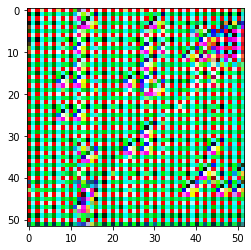

In [25]:
with torch.no_grad():
    img = generator.forward(1).squeeze(0).cpu()
    plt.imshow(img.permute(2,1,0))
    plt.show()
    